In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from fmpapi import fmp_get, fmp_set_api_key
from plotnine import *
from mizani.formatters import percent_format, comma_format
from itertools import product

In [4]:
api_key = "31rk2FooNwK9pNFzHWRKahod8M6EeMdl"

In [7]:
base = "https://financialmodelingprep.com/stable"

def fetch_df(path, params):
    url = f"{base}/{path}"
    resp = requests.get(url, params=params | {"apikey": api_key})
    if not resp.ok:
        raise RuntimeError(f"{path} error {resp.status_code}: {resp.text[:200]}")
    data = resp.json()
    # Some FMP endpoints return {"data":[...]} or a bare list. Handle both.
    rows = data.get("data", data) if isinstance(data, dict) else data
    return pd.DataFrame(rows)

In [8]:
symbol = "PEP"

common = {"symbol": symbol, "period": "annual", "limit": 5}

pep_income_statements = fetch_df("income-statement", common)
pep_balance_sheet     = fetch_df("balance-sheet-statement", common)
pep_cash_flow         = fetch_df("cash-flow-statement", common)

In [9]:
symbol = "KO"

common = {"symbol": symbol, "period": "annual", "limit": 5}

ko_income_statements = fetch_df("income-statement", common)
ko_balance_sheet     = fetch_df("balance-sheet-statement", common)
ko_cash_flow         = fetch_df("cash-flow-statement", common)

In [17]:
ko_income_statements

,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,revenue,costOfRevenue,...,netIncomeFromContinuingOperations,netIncomeFromDiscontinuedOperations,otherAdjustmentsToNetIncome,netIncome,netIncomeDeductions,bottomLineNetIncome,eps,epsDiluted,weightedAverageShsOut,weightedAverageShsOutDil
0,2024-12-31,KO,USD,0000021344,2025-02-20,2025-02-20 15:17:12,2024,FY,47061000000,18324000000,...,10649000000,0,0,10631000000,0,10631000000,2.47,2.46,4309000000,4320000000
1,2023-12-31,KO,USD,0000021344,2024-02-20,2024-02-20 13:21:24,2023,FY,45754000000,18520000000,...,10703000000,0,0,10714000000,0,10714000000,2.48,2.47,4323000000,4339000000
2,2022-12-31,KO,USD,0000021344,2023-02-21,2023-02-21 16:03:20,2022,FY,43004000000,18000000000,...,9571000000,0,0,9542000000,0,9542000000,2.20,2.19,4328000000,4350000000
3,2021-12-31,KO,USD,0000021344,2022-02-22,2022-02-22 15:45:48,2021,FY,38655000000,15357000000,...,9804000000,0,0,9771000000,0,9771000000,2.26,2.25,4315000000,4340000000
4,2020-12-31,KO,USD,0000021344,2021-02-25,2021-02-25 13:47:17,2020,FY,33014000000,13433000000,...,7768000000,0,0,7747000000,0,7747000000,1.80,1.79,4295000000,4323000000


In [18]:
ko_balance_sheet

,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,cashAndCashEquivalents,shortTermInvestments,...,additionalPaidInCapital,accumulatedOtherComprehensiveIncomeLoss,otherTotalStockholdersEquity,totalStockholdersEquity,totalEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
0,2024-12-31,KO,USD,0000021344,2025-02-20,2025-02-20 15:17:12,2024,FY,10828000000,3743000000,...,19801000000,-16843000000,0,24856000000,26372000000,1516000000,100549000000,23018000000,45735000000,34907000000
1,2023-12-31,KO,USD,0000021344,2024-02-20,2024-02-20 13:21:24,2023,FY,9366000000,4297000000,...,19209000000,-14275000000,0,25941000000,27480000000,1539000000,97703000000,24086000000,43426000000,34060000000
2,2022-12-31,KO,USD,0000021344,2023-02-21,2023-02-21 16:03:20,2022,FY,9519000000,2112000000,...,18822000000,-14895000000,0,24105000000,25826000000,1721000000,92763000000,20877000000,40603000000,31084000000
3,2021-12-31,KO,USD,0000021344,2022-02-22,2022-02-22 15:45:48,2021,FY,9684000000,2941000000,...,18116000000,-14330000000,0,22999000000,24860000000,1861000000,94354000000,21357000000,44232000000,34548000000
4,2020-12-31,KO,USD,0000021344,2021-02-25,2021-02-25 13:47:17,2020,FY,6795000000,4119000000,...,17601000000,-14601000000,0,19299000000,21284000000,1985000000,87296000000,24204000000,44415000000,37620000000


In [19]:
ko_cash_flow

,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,netIncome,depreciationAndAmortization,...,netCashProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,incomeTaxesPaid,interestPaid
0,2024-12-31,KO,USD,0000021344,2025-02-20,2025-02-20 15:17:12,2024,FY,10631000000,1075000000,...,-6910000000,-623000000,1796000000,11488000000,9692000000,6805000000,-2064000000,4741000000,0,0
1,2023-12-31,KO,USD,0000021344,2024-02-20,2024-02-20 13:21:24,2023,FY,10714000000,1128000000,...,-8310000000,-73000000,-133000000,9692000000,9825000000,11599000000,-1852000000,9747000000,0,0
2,2022-12-31,KO,USD,0000021344,2023-02-21,2023-02-21 16:03:20,2022,FY,9571000000,1260000000,...,-10250000000,-205000000,-200000000,9825000000,10025000000,11018000000,-1484000000,9534000000,0,0
3,2021-12-31,KO,USD,0000021344,2022-02-22,2022-02-22 15:45:48,2021,FY,9804000000,1452000000,...,-6786000000,-159000000,2915000000,10025000000,7110000000,12625000000,-1367000000,11258000000,0,0
4,2020-12-31,KO,USD,0000021344,2021-02-25,2021-02-25 13:47:17,2020,FY,7768000000,1536000000,...,-8070000000,76000000,373000000,7110000000,6737000000,9844000000,-1177000000,8667000000,0,0



📊 Exporting plots...
✅ Saved: performance_profitability.png
✅ Saved: efficiency.png
✅ Saved: liquidity.png
✅ Saved: leverage.png
✅ Saved: coverage.png
✅ Saved: market_ratios.png
✅ Saved: buybacks_cash_outflow.png
✅ Saved: diluted_shares_trend.png

📄 Combined PDF report saved: KO_vs_PEP_Financial_Ratios_Report.pdf



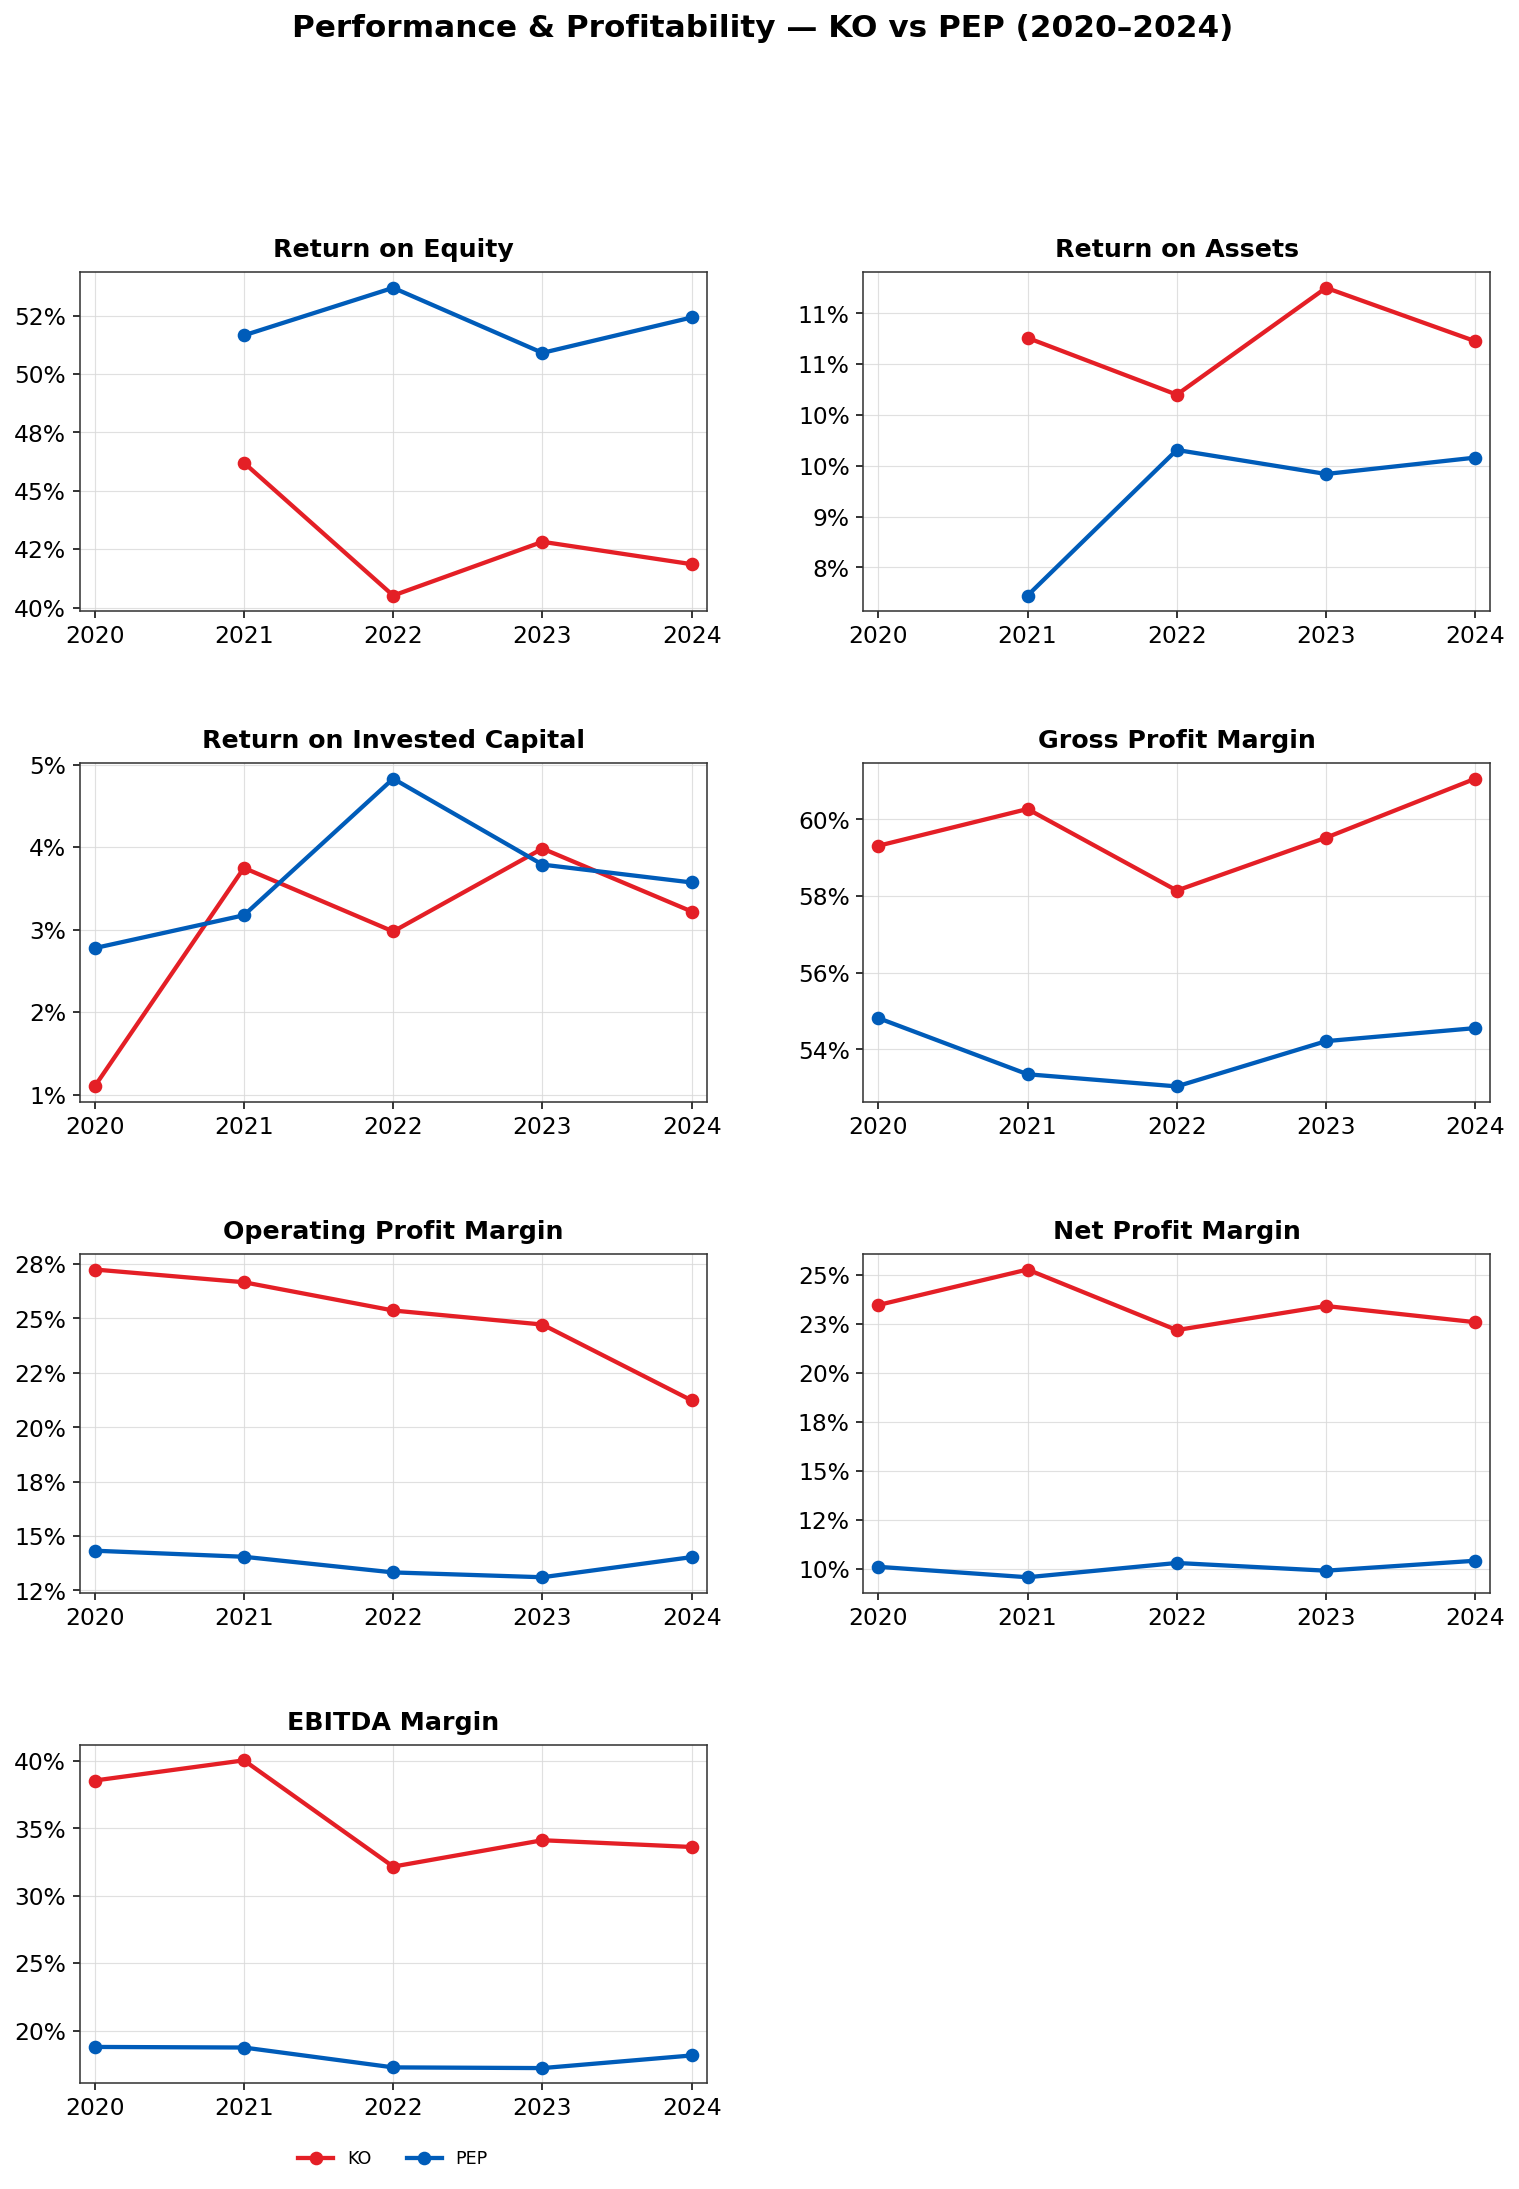

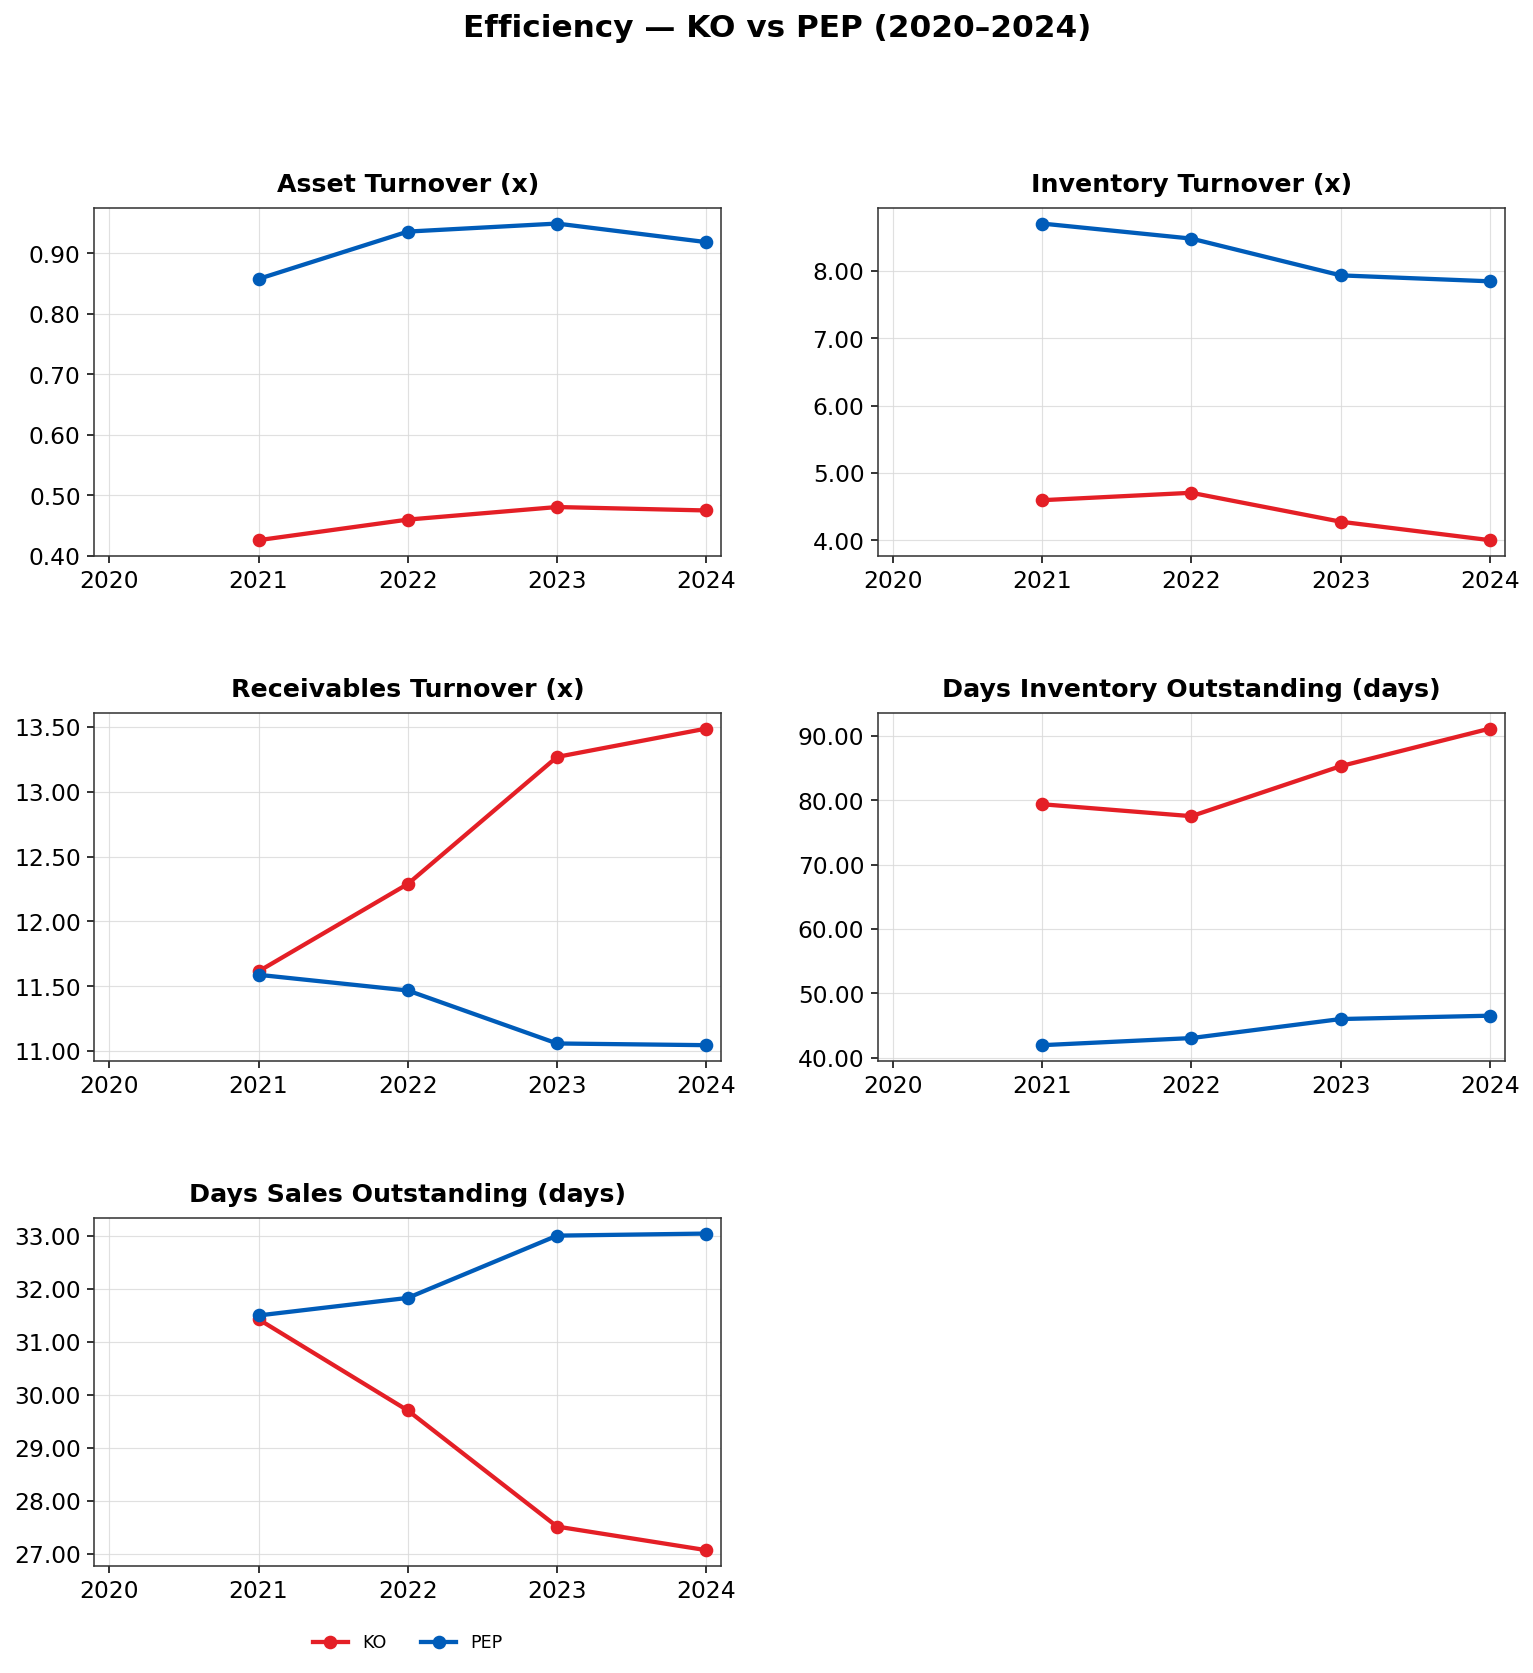

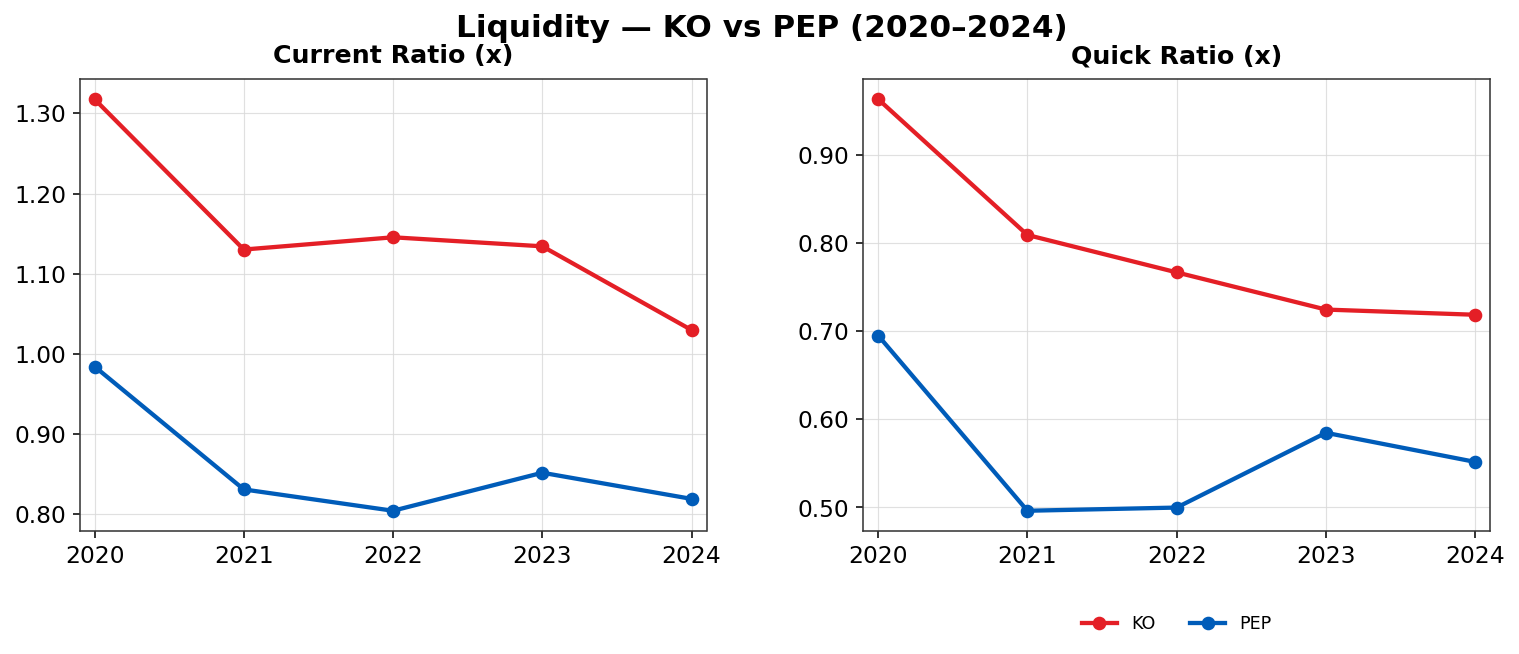

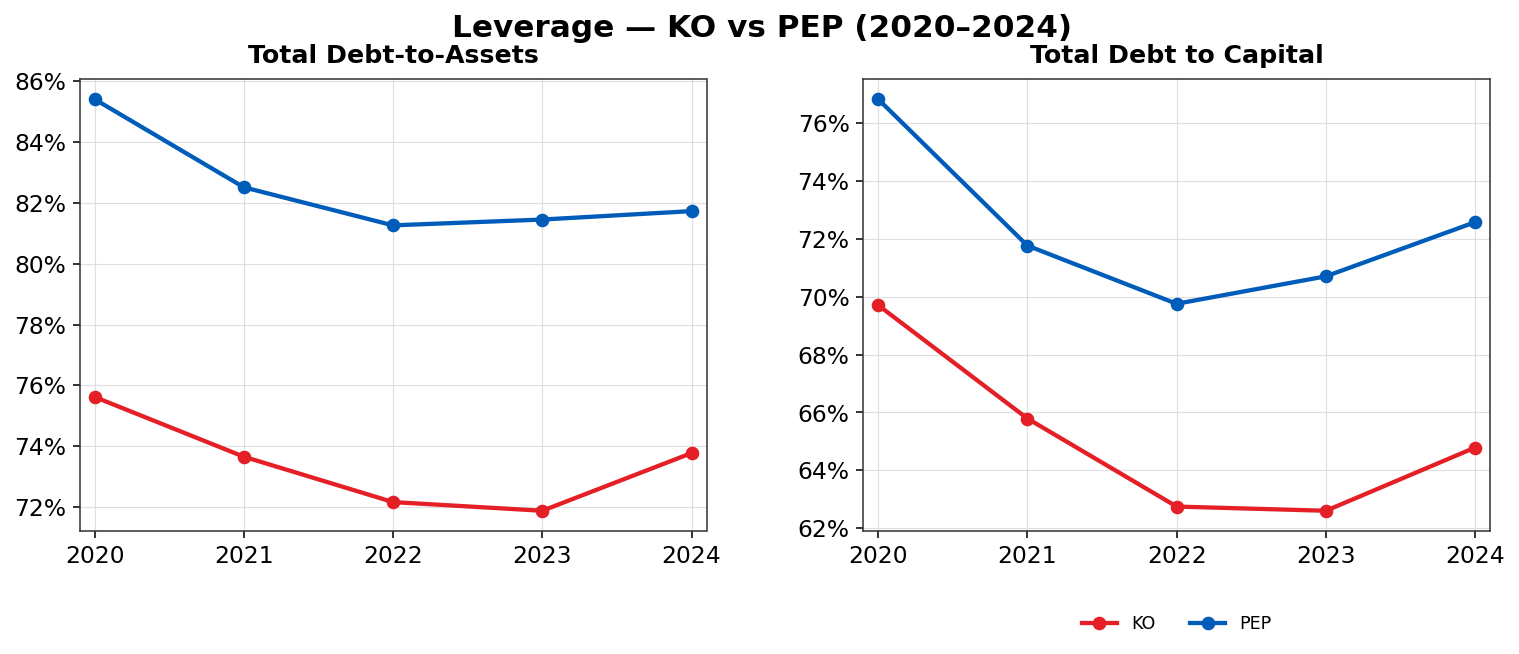

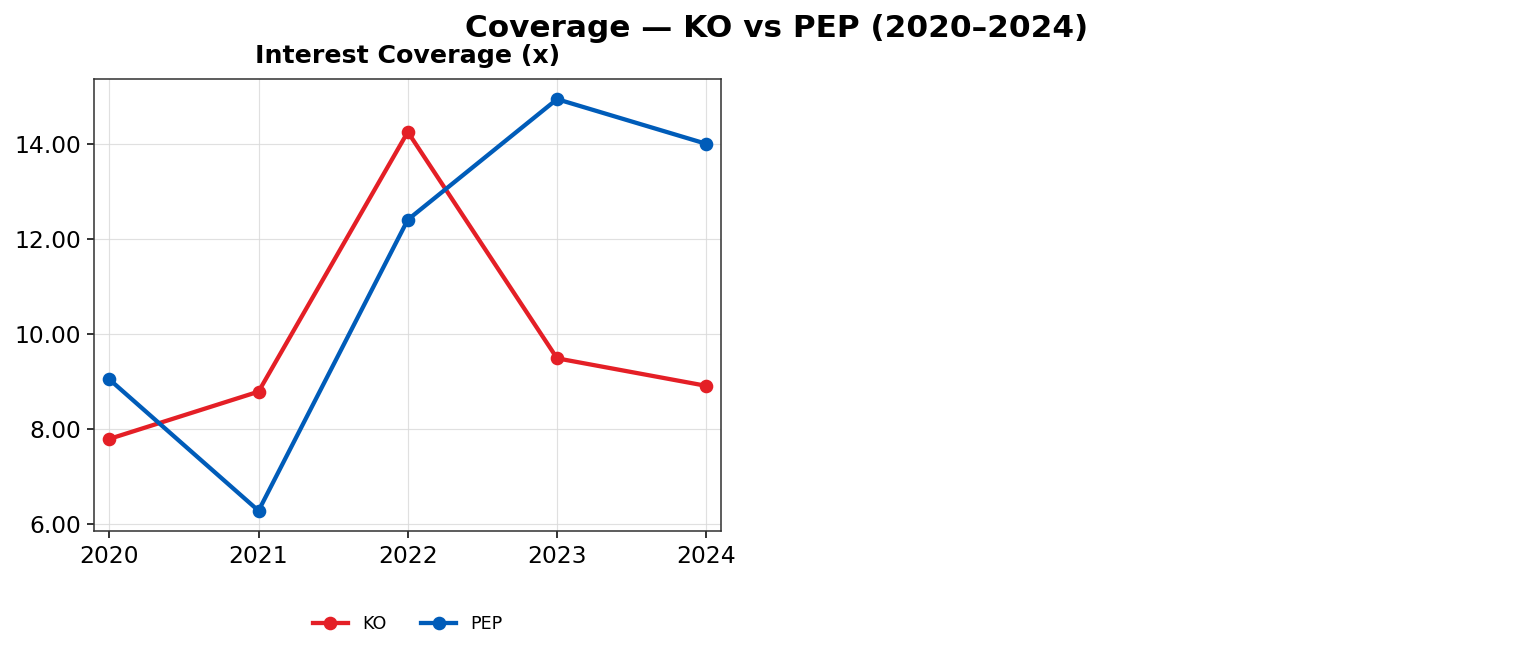

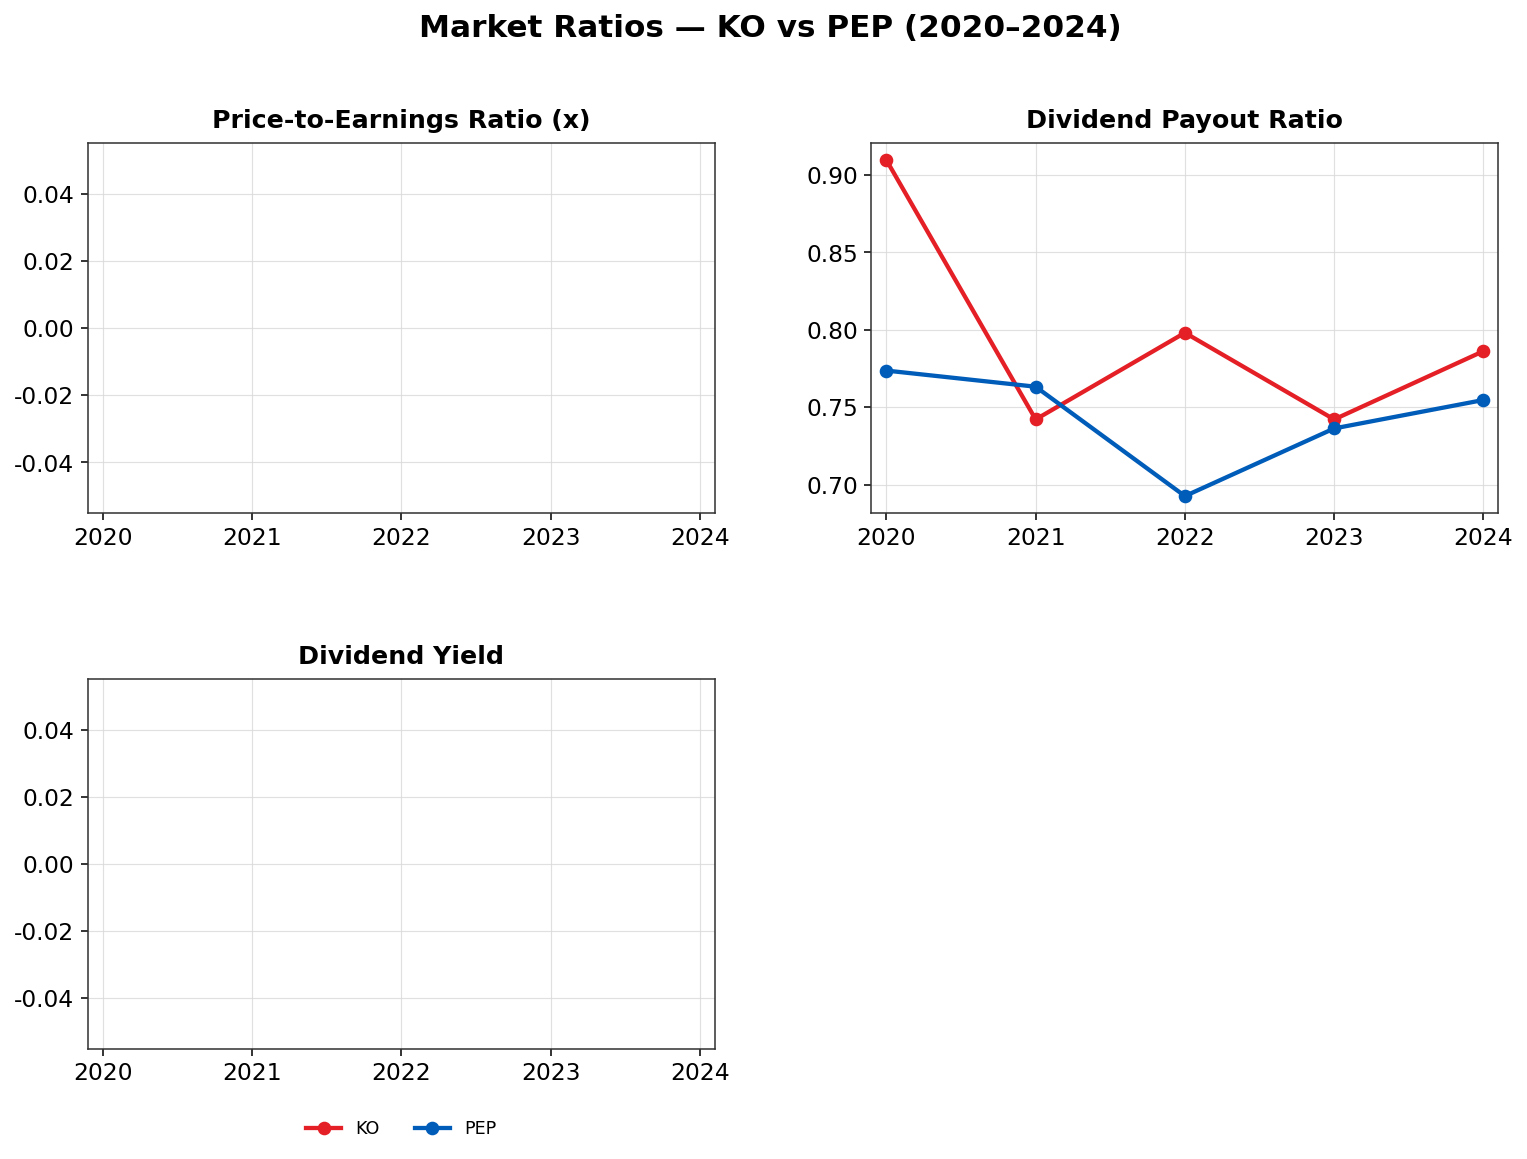

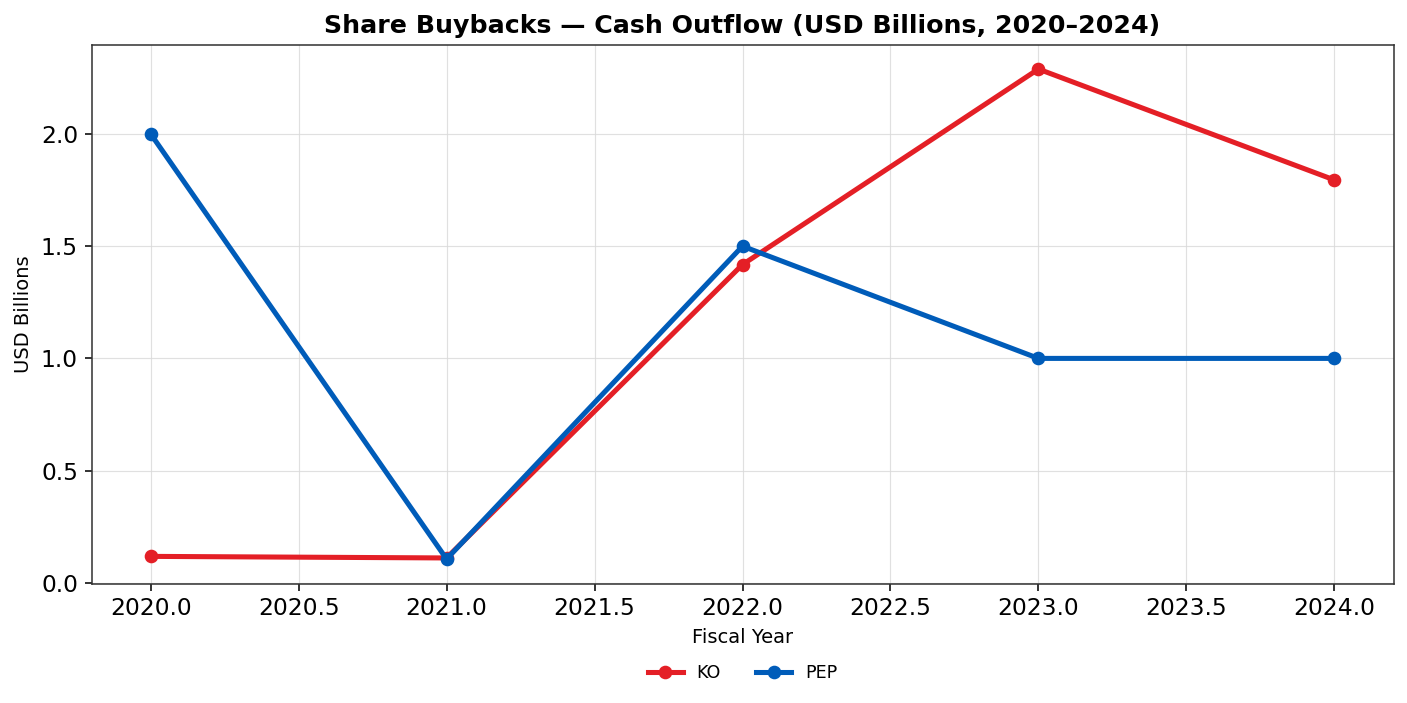

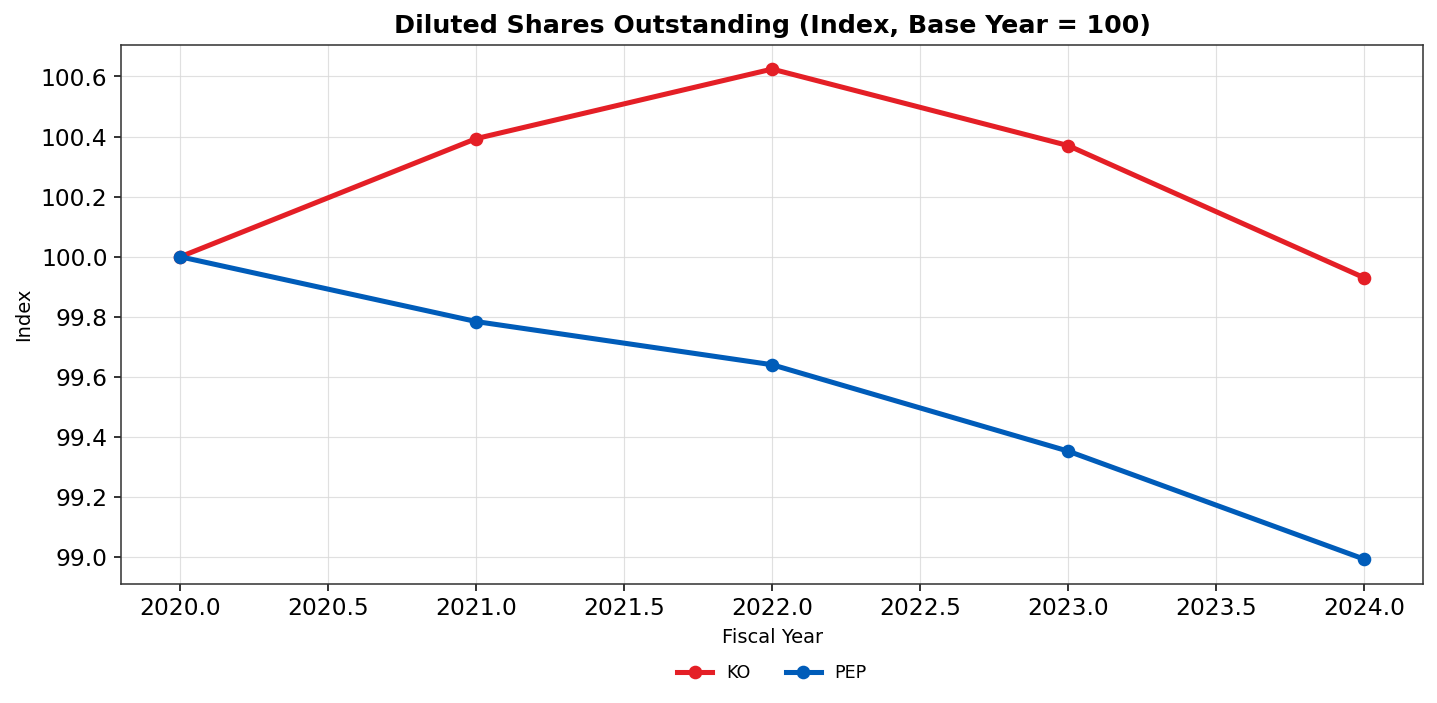

In [36]:
# ======================================
# C-SUITE RATIO DASHBOARD (KO vs PEP)
# Full Version with Market Ratios, Buybacks, Debt-to-Capital & Interest Coverage
# ======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl

# ----------------------------------------
# VISUAL STYLE CONFIG
# ----------------------------------------
mpl.rcParams.update({
    "figure.dpi": 140,
    "axes.titleweight": "bold",
    "axes.titlesize": 13,
    "axes.labelsize": 10,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
    "axes.grid": True,
    "grid.color": "#D9D9D9",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.8,
    "legend.frameon": False,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
})

COLORS = {
    "KO": "#E41F26",   # Coca-Cola red
    "PEP": "#005CB9",  # Pepsi blue
}

# ----------------------------------------
# Helper Formatters
# ----------------------------------------
def _pct_formatter(x, pos): return f"{x:.0%}"
def _two_decimal(x, pos): return f"{x:.2f}"

# ----------------------------------------
# CLEANING HELPERS
# ----------------------------------------
def _prep_is(df):
    keep = [
        "fiscalYear","symbol","revenue","costOfRevenue","grossProfit","ebitda","ebit",
        "operatingIncome","netIncome","interestExpense","incomeTaxExpense",
        "weightedAverageShsOut","weightedAverageShsOutDil","eps","epsDiluted"
    ]
    out = df[keep].copy()
    out = out.sort_values("fiscalYear").drop_duplicates("fiscalYear", keep="last")
    for c in out.columns:
        if c not in ["symbol"]:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    out["DilutedShares"] = out["weightedAverageShsOutDil"].fillna(out["weightedAverageShsOut"])
    return out

def _prep_bs(df):
    keep = [
        "fiscalYear","symbol","totalAssets","totalCurrentAssets","inventory","netReceivables",
        "accountsReceivables","totalCurrentLiabilities","totalLiabilities",
        "totalStockholdersEquity","totalEquity","totalDebt","cashAndCashEquivalents",
        "shortTermInvestments"
    ]
    out = df[keep].copy()
    out = out.sort_values("fiscalYear").drop_duplicates("fiscalYear", keep="last")
    for c in out.columns:
        if c not in ["symbol"]:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _prep_cf(df):
    keep = [
        "fiscalYear","symbol",
        "commonDividendsPaid","netDividendsPaid",
        "interestPaid","operatingCashFlow","capitalExpenditure","freeCashFlow",
        "netStockIssuance","netCommonStockIssuance","commonStockIssuance","commonStockRepurchased"
    ]
    out = df[keep].copy()
    out = out.sort_values("fiscalYear").drop_duplicates("fiscalYear", keep="last")
    for c in out.columns:
        if c not in ["symbol"]:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _avg(series): return (series + series.shift(1)) / 2.0

# ----------------------------------------
# COMPUTE RATIOS (including Market Ratios)
# ----------------------------------------
def compute_ratios(company, is_df, bs_df, cf_df):
    is_df, bs_df, cf_df = _prep_is(is_df), _prep_bs(bs_df), _prep_cf(cf_df)
    df = (is_df.merge(bs_df, on=["fiscalYear","symbol"], how="outer")
               .merge(cf_df, on=["fiscalYear","symbol"], how="outer"))
    df = df.sort_values("fiscalYear")

    df["equity"] = df["totalStockholdersEquity"].fillna(df["totalEquity"])
    df["receivables"] = df["accountsReceivables"].fillna(df["netReceivables"])
    df["avg_assets"] = _avg(df["totalAssets"])
    df["avg_equity"] = _avg(df["equity"])
    df["avg_inventory"] = _avg(df["inventory"])
    df["avg_receivables"] = _avg(df["receivables"])

    dividends = df["commonDividendsPaid"].fillna(df["netDividendsPaid"]).abs()

    # --- Profitability ---
    df["ROE"] = df["netIncome"] / df["avg_equity"]
    df["ROA"] = df["netIncome"] / df["avg_assets"]
    df["ROIC"] = (df["netIncome"] - dividends) / (df["totalDebt"] + df["equity"])
    df["Gross Margin"] = df["grossProfit"] / df["revenue"]
    df["Operating Margin"] = df["operatingIncome"] / df["revenue"]
    df["Net Margin"] = df["netIncome"] / df["revenue"]
    df["EBITDA Margin"] = df["ebitda"] / df["revenue"]

    # --- Efficiency ---
    df["Asset Turnover"] = df["revenue"] / df["avg_assets"]
    df["Inventory Turnover"] = df["costOfRevenue"] / df["avg_inventory"]
    df["Receivables Turnover"] = df["revenue"] / df["avg_receivables"]
    df["Days Inventory Outstanding"] = 365 / df["Inventory Turnover"]
    df["Days Sales Outstanding"] = 365 / df["Receivables Turnover"]

    # --- Leverage & Liquidity ---
    df["Debt-to-Assets"] = df["totalLiabilities"] / df["totalAssets"]

    # NEW: Total Debt to Capital = totalDebt / (totalDebt + equity)
    denom_capital = (df["totalDebt"] + df["equity"])
    df["Debt-to-Capital"] = np.where(denom_capital != 0, df["totalDebt"] / denom_capital, np.nan)

    df["Current Ratio"] = df["totalCurrentAssets"] / df["totalCurrentLiabilities"]
    quick = df["cashAndCashEquivalents"].fillna(0) + df["shortTermInvestments"].fillna(0) + df["receivables"].fillna(0)
    df["Quick Ratio"] = quick / df["totalCurrentLiabilities"]

    # --- Coverage ---
    # Interest Coverage = EBIT / |Interest Expense|
    # (Use absolute value to handle data sources that store interest as negative.)
    interest = df["interestExpense"].abs()
    df["Interest Coverage"] = np.where((interest.notna()) & (interest != 0), df["ebit"] / interest, np.nan)

    # --- Market Ratios ---
    df["EPS"] = df["epsDiluted"].fillna(df["eps"])
    if "marketPrice" in df.columns:
        df["P/E Ratio"] = df["marketPrice"] / df["EPS"]
        df["Dividend Yield"] = (dividends.abs() / df["DilutedShares"]) / df["marketPrice"]
    else:
        df["P/E Ratio"] = np.nan
        df["Dividend Yield"] = np.nan
    df["Dividend Payout Ratio"] = dividends / df["netIncome"]

    df["Year"] = df["fiscalYear"].astype(int)
    df["Company"] = company

    keep_cols = [
        "Year","Company",
        "ROE","ROA","ROIC","Gross Margin","Operating Margin","Net Margin","EBITDA Margin",
        "Asset Turnover","Inventory Turnover","Receivables Turnover",
        "Days Inventory Outstanding","Days Sales Outstanding",
        "Debt-to-Assets","Debt-to-Capital","Current Ratio","Quick Ratio",
        "Interest Coverage",
        "P/E Ratio","Dividend Payout Ratio","Dividend Yield"
    ]
    return df[keep_cols]

# ----------------------------------------
# BUYBACKS FUNCTION
# ----------------------------------------
def compute_buybacks(company, cf_df, is_df):
    cf = _prep_cf(cf_df)
    isd = _prep_is(is_df)[["fiscalYear", "symbol", "DilutedShares"]]
    df = cf.merge(isd, on=["fiscalYear", "symbol"], how="outer").sort_values("fiscalYear")

    gross = df["commonStockRepurchased"].abs()
    net_iss = df["netCommonStockIssuance"]
    if net_iss is None or net_iss.isna().all():
        net_iss = df.get("netStockIssuance")

    net_buyback = pd.Series(
        np.where(net_iss.notna(), np.maximum(-net_iss, 0), np.nan),
        index=df.index
    )
    df["Buybacks_Cash"] = gross.fillna(net_buyback)
    df["Buybacks_Cash_Bn"] = df["Buybacks_Cash"] / 1e9

    df = df.rename(columns={"fiscalYear": "Year"})
    base_year = df["Year"].min()
    base_sh = df.loc[df["Year"] == base_year, "DilutedShares"]
    base_val = base_sh.iloc[0] if len(base_sh) else np.nan
    if pd.notna(base_val) and base_val != 0:
        df["Shares_Index"] = (df["DilutedShares"] / base_val) * 100
    else:
        df["Shares_Index"] = np.nan

    df["Company"] = company
    return df[["Year", "Company", "Buybacks_Cash_Bn", "Shares_Index"]]

# ----------------------------------------
# COMPUTE ALL
# ----------------------------------------
ko_ratios = compute_ratios("KO", ko_income_statements, ko_balance_sheet, ko_cash_flow)
pep_ratios = compute_ratios("PEP", pep_income_statements, pep_balance_sheet, pep_cash_flow)
ratios_all = pd.concat([ko_ratios, pep_ratios], ignore_index=True)

ko_bb = compute_buybacks("KO", ko_cash_flow, ko_income_statements)
pep_bb = compute_buybacks("PEP", pep_cash_flow, pep_income_statements)
buybacks_all = pd.concat([ko_bb, pep_bb], ignore_index=True).sort_values(["Year","Company"])

# ----------------------------------------
# PLOTTING HELPERS
# ----------------------------------------
def create_canvas_2cols(n_panels, title=None):
    cols = 2
    rows = int(np.ceil(n_panels / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(13, 4.2*rows),
                             gridspec_kw={'wspace': 0.25, 'hspace': 0.45})
    fig.patch.set_facecolor("white")
    axes = np.atleast_1d(axes).ravel()
    for j in range(n_panels, len(axes)):
        axes[j].axis("off")
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold", y=0.99)
    return fig, axes[:n_panels]

def plot_category(axarr, data, metrics, yformat="ratio"):
    formatter = FuncFormatter(_pct_formatter if yformat=="ratio" else _two_decimal)
    for i, (key, label) in enumerate(metrics):
        ax = axarr[i]
        for comp, color in COLORS.items():
            d = data[data["Company"]==comp]
            ax.plot(d["Year"], d[key], marker="o", linewidth=2.2, color=color, label=comp)
        ax.set_title(label, loc="center", pad=8)
        ax.set_xlim(data["Year"].min()-0.1, data["Year"].max()+0.1)
        ax.grid(True)
        ax.yaxis.set_major_formatter(formatter)
        ax.set_facecolor("white")
    handles, labels = axarr[0].get_legend_handles_labels()
    axarr[-1].legend(handles, labels, ncols=2, loc="upper center",
                     bbox_to_anchor=(0.5, -0.15))

# ----------------------------------------
# CATEGORY PLOTS
# ----------------------------------------
perf_metrics = [
    ("ROE", "Return on Equity"),
    ("ROA", "Return on Assets"),
    ("ROIC", "Return on Invested Capital"),
    ("Gross Margin", "Gross Profit Margin"),
    ("Operating Margin", "Operating Profit Margin"),
    ("Net Margin", "Net Profit Margin"),
    ("EBITDA Margin", "EBITDA Margin"),
]
fig_perf, ax_perf = create_canvas_2cols(len(perf_metrics),
    "Performance & Profitability — KO vs PEP (2020–2024)")
plot_category(ax_perf, ratios_all, perf_metrics, yformat="ratio")

eff_metrics = [
    ("Asset Turnover", "Asset Turnover (x)"),
    ("Inventory Turnover", "Inventory Turnover (x)"),
    ("Receivables Turnover", "Receivables Turnover (x)"),
    ("Days Inventory Outstanding", "Days Inventory Outstanding (days)"),
    ("Days Sales Outstanding", "Days Sales Outstanding (days)"),
]
fig_eff, ax_eff = create_canvas_2cols(len(eff_metrics),
    "Efficiency — KO vs PEP (2020–2024)")
plot_category(ax_eff, ratios_all, eff_metrics, yformat="2dp")

liq_metrics = [
    ("Current Ratio", "Current Ratio (x)"),
    ("Quick Ratio", "Quick Ratio (x)"),
]
fig_liq, ax_liq = create_canvas_2cols(len(liq_metrics),
    "Liquidity — KO vs PEP (2020–2024)")
plot_category(ax_liq, ratios_all, liq_metrics, yformat="2dp")

lev_metrics = [
    ("Debt-to-Assets", "Total Debt-to-Assets"),
    ("Debt-to-Capital", "Total Debt to Capital"),
]
fig_lev, ax_lev = create_canvas_2cols(len(lev_metrics),
    "Leverage — KO vs PEP (2020–2024)")
plot_category(ax_lev, ratios_all, lev_metrics, yformat="ratio")

coverage_metrics = [
    ("Interest Coverage", "Interest Coverage (x)"),
]
fig_cov, ax_cov = create_canvas_2cols(len(coverage_metrics),
    "Coverage — KO vs PEP (2020–2024)")
plot_category(ax_cov, ratios_all, coverage_metrics, yformat="2dp")

market_metrics = [
    ("P/E Ratio", "Price-to-Earnings Ratio (x)"),
    ("Dividend Payout Ratio", "Dividend Payout Ratio"),
    ("Dividend Yield", "Dividend Yield"),
]
fig_market, ax_market = create_canvas_2cols(len(market_metrics),
    "Market Ratios — KO vs PEP (2020–2024)")
plot_category(ax_market, ratios_all, market_metrics, yformat="2dp")

# ----------------------------------------
# BUYBACK PLOTS
# ----------------------------------------
fig_bb_cash, ax_bb_cash = plt.subplots(figsize=(12, 5))
for comp, color in COLORS.items():
    d = buybacks_all[buybacks_all["Company"]==comp]
    ax_bb_cash.plot(d["Year"], d["Buybacks_Cash_Bn"], marker="o", linewidth=2.6, color=color, label=comp)
ax_bb_cash.set_title("Share Buybacks — Cash Outflow (USD Billions, 2020–2024)")
ax_bb_cash.set_xlabel("Fiscal Year")
ax_bb_cash.set_ylabel("USD Billions")
ax_bb_cash.grid(True)
ax_bb_cash.legend(ncols=2, loc="upper center", bbox_to_anchor=(0.5, -0.12))
ax_bb_cash.set_facecolor("white")

fig_bb_shares, ax_bb_shares = plt.subplots(figsize=(12, 5))
for comp, color in COLORS.items():
    d = buybacks_all[buybacks_all["Company"]==comp]
    ax_bb_shares.plot(d["Year"], d["Shares_Index"], marker="o", linewidth=2.6, color=color, label=comp)
ax_bb_shares.set_title("Diluted Shares Outstanding (Index, Base Year = 100)")
ax_bb_shares.set_xlabel("Fiscal Year")
ax_bb_shares.set_ylabel("Index")
ax_bb_shares.grid(True)
ax_bb_shares.legend(ncols=2, loc="upper center", bbox_to_anchor=(0.5, -0.12))
ax_bb_shares.set_facecolor("white")

# ----------------------------------------
# EXPORT ALL FIGURES
# ----------------------------------------
plots = {
    "performance_profitability.png": fig_perf,
    "efficiency.png": fig_eff,
    "liquidity.png": fig_liq,
    "leverage.png": fig_lev,
    "coverage.png": fig_cov,
    "market_ratios.png": fig_market,
    "buybacks_cash_outflow.png": fig_bb_cash,
    "diluted_shares_trend.png": fig_bb_shares,
}

print("\n📊 Exporting plots...")

for fname, fig in plots.items():
    fig.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")
    print(f"✅ Saved: {fname}")

pdf_filename = "KO_vs_PEP_Financial_Ratios_Report.pdf"
with PdfPages(pdf_filename) as pdf:
    for _, fig in plots.items():
        pdf.savefig(fig, bbox_inches="tight", facecolor="white")

print(f"\n📄 Combined PDF report saved: {pdf_filename}\n")

plt.show()


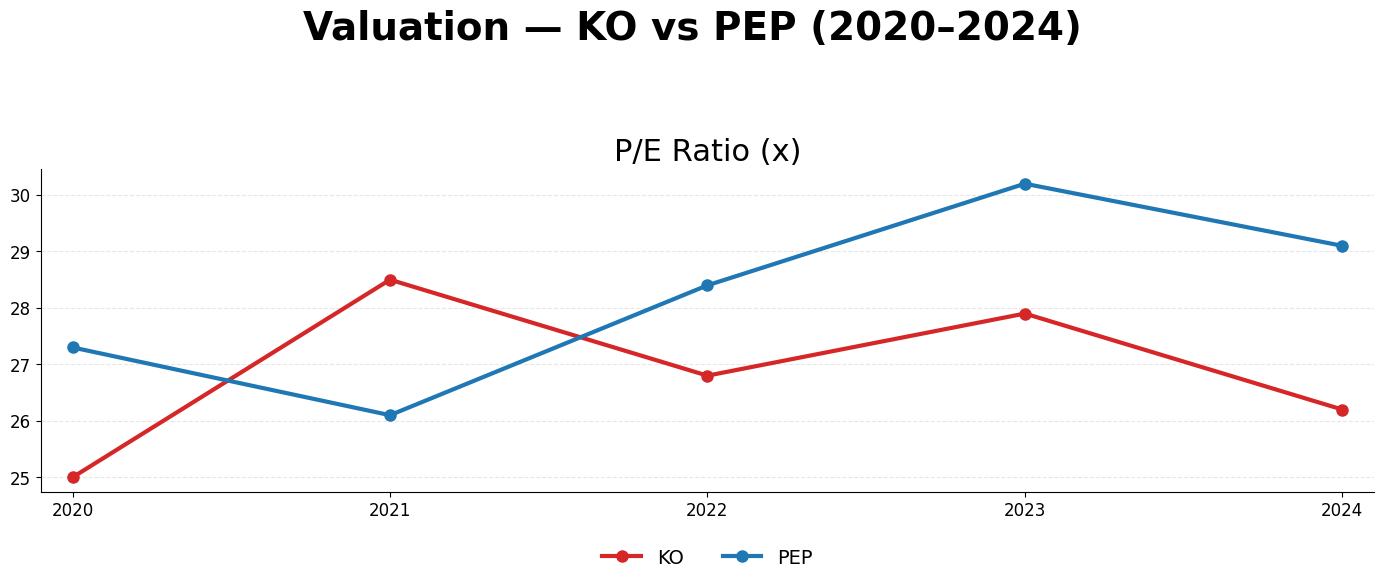

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# =======================
# 1) INPUT YOUR DATA HERE
# =======================
years  = np.array([2020, 2021, 2022, 2023, 2024])

# Replace with your actual P/E ratios (example placeholders below)
ko_pe  = np.array([25.0, 28.5, 26.8, 27.9, 26.2])  # KO P/E
pep_pe = np.array([27.3, 26.1, 28.4, 30.2, 29.1])  # PEP P/E

# =======================
# 2) STYLING TO MATCH THE ATTACHED CHART
# =======================
plt.style.use("default")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 22,
    "axes.labelsize": 16,
    "figure.titlesize": 28,
    "legend.fontsize": 14
})

fig, ax = plt.subplots(figsize=(14, 6))  # single metric, one wide panel

# Title & subtitle (mirroring the look/feel)
fig.suptitle("Valuation — KO vs PEP (2020–2024)", y=1.02, fontweight="bold")
ax.set_title("P/E Ratio (x)")

# Lines (colors match your style: KO=red, PEP=blue)
ax.plot(years, ko_pe, marker="o", markersize=8, linewidth=3, color="#d62728", label="KO")
ax.plot(years, pep_pe, marker="o", markersize=8, linewidth=3, color="#1f77b4", label="PEP")

# Axes formatting
ax.set_xticks(years)
ax.set_xlim(years.min() - 0.1, years.max() + 0.1)
ax.grid(True, axis="y", linestyle="--", alpha=0.3)

# Light spine cleanup similar to your samples
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Legend (bottom center, two columns)
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

# Tighter layout with room for the suptitle and legend
plt.tight_layout(rect=[0, 0.02, 1, 0.93])
plt.show()


In [35]:
import pandas as pd

def first_col(df, *cands, required=True):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {cands} found. Available: {list(df.columns)}")
    return None

def add_year(df):
    if df is None or df.empty:
        return pd.DataFrame(columns=["year"])
    if "fiscalYear" in df.columns:
        return df.assign(year=pd.to_numeric(df["fiscalYear"], errors="coerce").astype("Int64"))
    if "calendarYear" in df.columns:
        return df.assign(year=pd.to_numeric(df["calendarYear"], errors="coerce").astype("Int64"))
    if "calendar_year" in df.columns:
        return df.assign(year=pd.to_numeric(df["calendar_year"], errors="coerce").astype("Int64"))
    if "date" in df.columns:
        return df.assign(year=pd.to_datetime(df["date"], errors="coerce").dt.year.astype("Int64"))
    # fallback: leave empty
    return df.assign(year=pd.Series(dtype="Int64"))

# ---- Income side ----
inc = add_year(income_statements).copy()

# pick columns (camelCase first, then snake_case)
col_net_income = first_col(inc, "netIncome", "net_income")
col_tax        = first_col(inc, "incomeTaxExpense", "income_tax_expense")
col_int_exp    = first_col(inc, "interestExpense", "interest_expense", required=False)
col_int_inc    = first_col(inc, "interestIncome", "interest_income", required=False)
col_rev        = first_col(inc, "revenue")
col_depr       = first_col(inc, "depreciationAndAmortization", "depreciation_and_amortization", required=False)

# EBIT (use existing 'ebit' if present, else compute)
if "ebit" in inc.columns:
    inc["ebit_calc"] = pd.to_numeric(inc["ebit"], errors="coerce")
else:
    inc["ebit_calc"] = (
        pd.to_numeric(inc[col_net_income], errors="coerce").fillna(0.0)
        + pd.to_numeric(inc[col_tax], errors="coerce").fillna(0.0)
        + (pd.to_numeric(inc[col_int_exp], errors="coerce").fillna(0.0) if col_int_exp else 0.0)
        - (pd.to_numeric(inc[col_int_inc], errors="coerce").fillna(0.0) if col_int_inc else 0.0)
    )

dcf_left = (
    inc.rename(columns={col_tax: "taxes", col_rev: "revenue"})
       .assign(depr=lambda x: pd.to_numeric(x[col_depr], errors="coerce") if col_depr else 0.0)
       .loc[:, ["year", "ebit_calc", "revenue", "depr", "taxes"]]
       .rename(columns={"ebit_calc": "ebit", "depr": "depreciationAndAmortization"})
)

# ---- Cash-flow side ----
if cash_flow_statements is None or cash_flow_statements.empty:
    cf_norm = pd.DataFrame({
        "year": dcf_left["year"].astype("Int64"),
        "delta_working_capital": 0.0,
        "capex": 0.0,
    })
else:
    cf = add_year(cash_flow_statements).copy()

    # ΔWC
    wc_col = first_col(cf, "changeInWorkingCapital", "change_in_working_capital", required=False)
    if wc_col:
        cf["delta_working_capital"] = pd.to_numeric(cf[wc_col], errors="coerce").fillna(0.0)
    else:
        cf["delta_working_capital"] = 0.0

    # Capex (several possible names)
    if "capitalExpenditure" in cf.columns:
        capex_series = cf["capitalExpenditure"]
    elif "capitalExpenditures" in cf.columns:
        capex_series = cf["capitalExpenditures"]
    elif "capital_expenditure" in cf.columns:
        capex_series = cf["capital_expenditure"]
    elif "investmentsInPropertyPlantAndEquipment" in cf.columns:
        # Usually a negative cash outflow; convert to positive capex
        capex_series = -pd.to_numeric(cf["investmentsInPropertyPlantAndEquipment"], errors="coerce")
    else:
        capex_series = 0.0
    cf["capex"] = pd.to_numeric(capex_series, errors="coerce").fillna(0.0)

    cf_norm = cf.loc[:, ["year", "delta_working_capital", "capex"]]

# ---- Final DCF table ----
dcf_data = (
    dcf_left.merge(cf_norm, on="year", how="left")
            .assign(
                delta_working_capital=lambda x: x["delta_working_capital"].fillna(0.0),
                capex=lambda x: x["capex"].fillna(0.0),
                depreciationAndAmortization=lambda x: x["depreciationAndAmortization"].fillna(0.0),
                taxes=lambda x: x["taxes"].fillna(0.0),
                fcf=lambda x: x["ebit"] + x["depreciationAndAmortization"] - x["taxes"]
                              + x["delta_working_capital"] - x["capex"]
            )
            .sort_values("year")
            .reset_index(drop=True)
)

print(dcf_data.head())


   year         ebit      revenue  depreciationAndAmortization       taxes  \
0  2020  10197000000  70372000000                   3026000000  1894000000   
1  2021  11684000000  79474000000                   3215000000  2142000000   
2  2022  11644000000  86392000000                   3280000000  1727000000   
3  2023  12236000000  91471000000                   3518000000  2262000000   
4  2024  12865000000  91854000000                   3815000000  2320000000   

   delta_working_capital  capex           fcf  
0                    0.0    0.0  1.132900e+10  
1                    0.0    0.0  1.275700e+10  
2                    0.0    0.0  1.319700e+10  
3                    0.0    0.0  1.349200e+10  
4                    0.0    0.0  1.436000e+10  


In [36]:
dcf_data

,year,ebit,revenue,depreciationAndAmortization,taxes,delta_working_capital,capex,fcf
0,2020,10197000000,70372000000,3026000000,1894000000,0.0,0.0,1.132900e+10
1,2021,11684000000,79474000000,3215000000,2142000000,0.0,0.0,1.275700e+10
2,2022,11644000000,86392000000,3280000000,1727000000,0.0,0.0,1.319700e+10
3,2023,12236000000,91471000000,3518000000,2262000000,0.0,0.0,1.349200e+10
4,2024,12865000000,91854000000,3815000000,2320000000,0.0,0.0,1.436000e+10


/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/mizani/palettes.py:557: UserWarning: Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


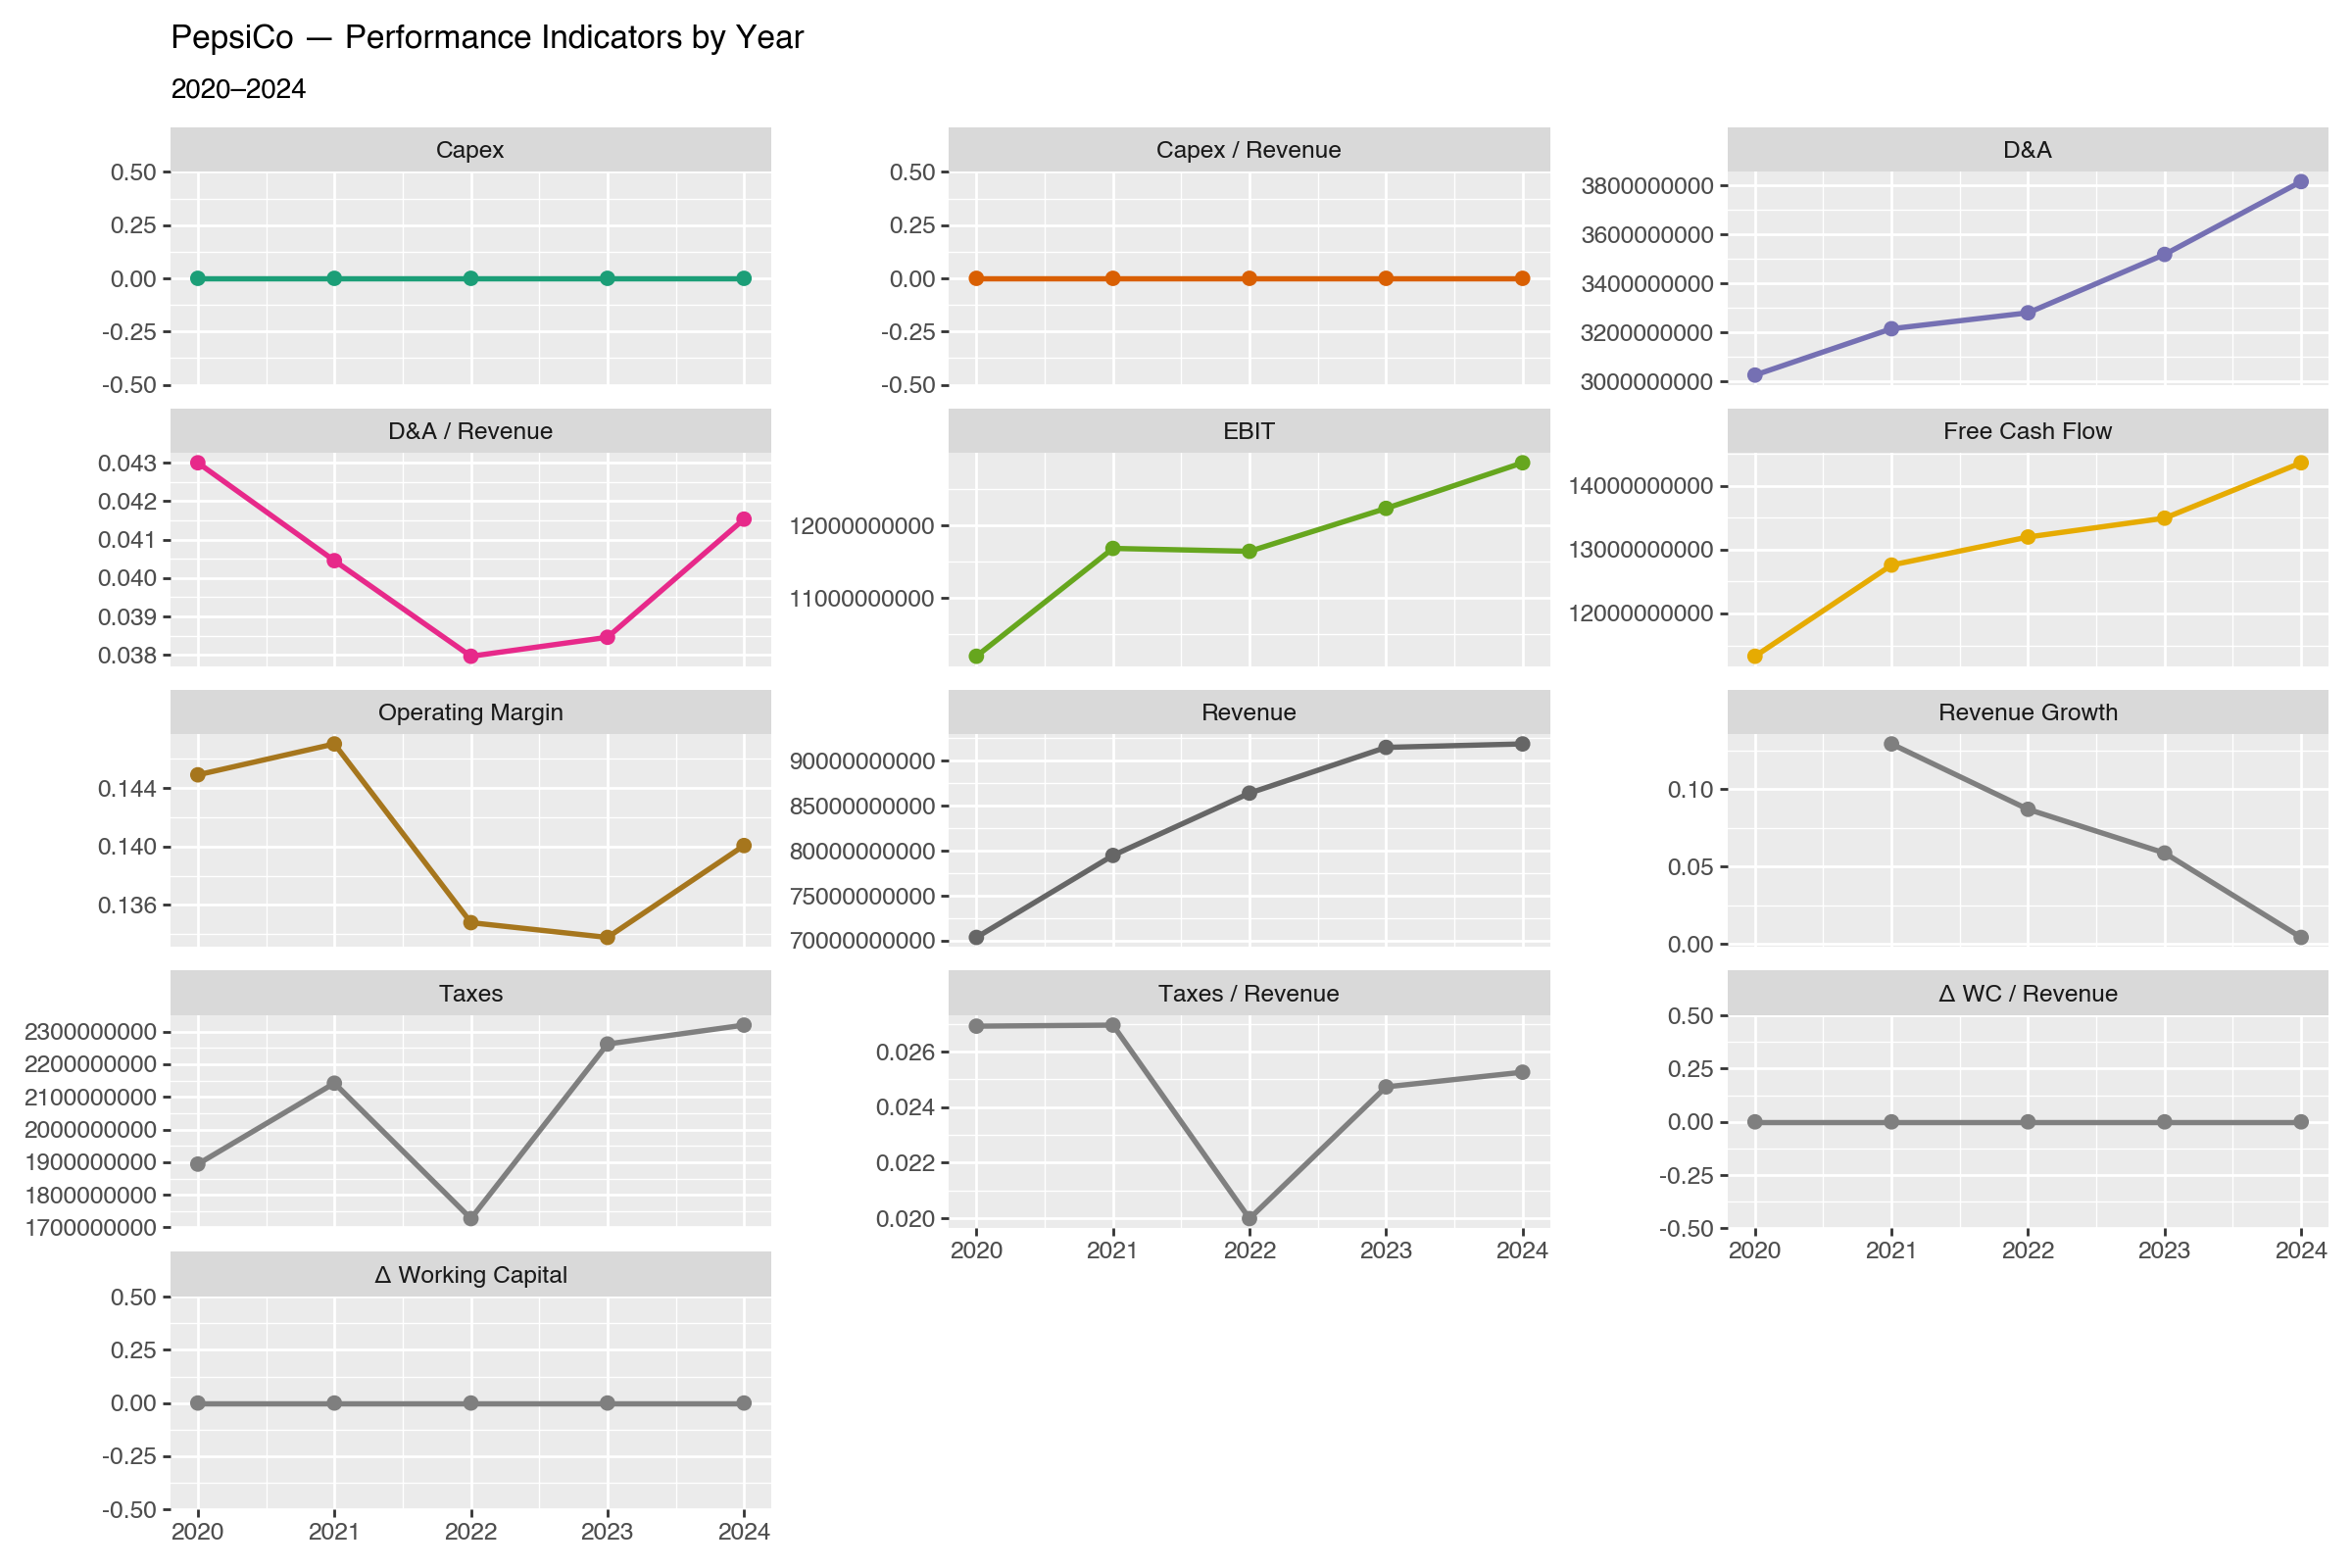

In [41]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap, labs, scale_y_continuous,
    scale_color_brewer, theme, element_text
)
from mizani.formatters import percent_format

# Pretty names for facet labels
nice_names = {
    "revenue": "Revenue",
    "ebit": "EBIT",
    "depreciationAndAmortization": "D&A",
    "taxes": "Taxes",
    "delta_working_capital": "Δ Working Capital",
    "capex": "Capex",
    "fcf": "Free Cash Flow",
    "revenue_growth": "Revenue Growth",
    "operating_margin": "Operating Margin",
    "da_margin": "D&A / Revenue",
    "taxes_to_revenue": "Taxes / Revenue",
    "delta_working_capital_to_revenue": "Δ WC / Revenue",
    "capex_to_revenue": "Capex / Revenue",
}

# make a readable copy
perf_plot = performance_long.copy()
perf_plot["indicator"] = perf_plot["indicator"].map(lambda s: nice_names.get(s, s))

# separate ratio vs absolute for proper y formatting
ratio_names = {
    "Revenue Growth", "Operating Margin", "D&A / Revenue", "Taxes / Revenue",
    "Δ WC / Revenue", "Capex / Revenue"
}

def pct_if_ratio(breaks, i):
    # percent axis only for ratio facets
    # plotnine calls the formatter with (breaks, tick_index)
    return [f"{b*100:.0f}%" for b in breaks]

plot_facets = (
    ggplot(perf_plot, aes("year", "value", color="indicator", group="indicator"))
    + geom_line(size=1.1)
    + geom_point(size=2.2)
    + facet_wrap("~indicator", scales="free_y", ncol=3)
    + scale_color_brewer(type="qualitative", palette="Dark2")
    + scale_y_continuous()  # (kept generic; each panel has free_y)
    + labs(
        title=f"PepsiCo — Performance Indicators by Year",
        subtitle=f"{int(dcf_data['year'].min())}–{int(dcf_data['year'].max())}",
        x="", y="", color=""
    )
    + theme(
        figure_size=(12, 8),
        axis_text_x=element_text(rotation=0, ha="center"),
        legend_position="none",
        plot_title=element_text(weight="bold", size=12),
        plot_subtitle=element_text(size=10)
    )
)
plot_facets.show()


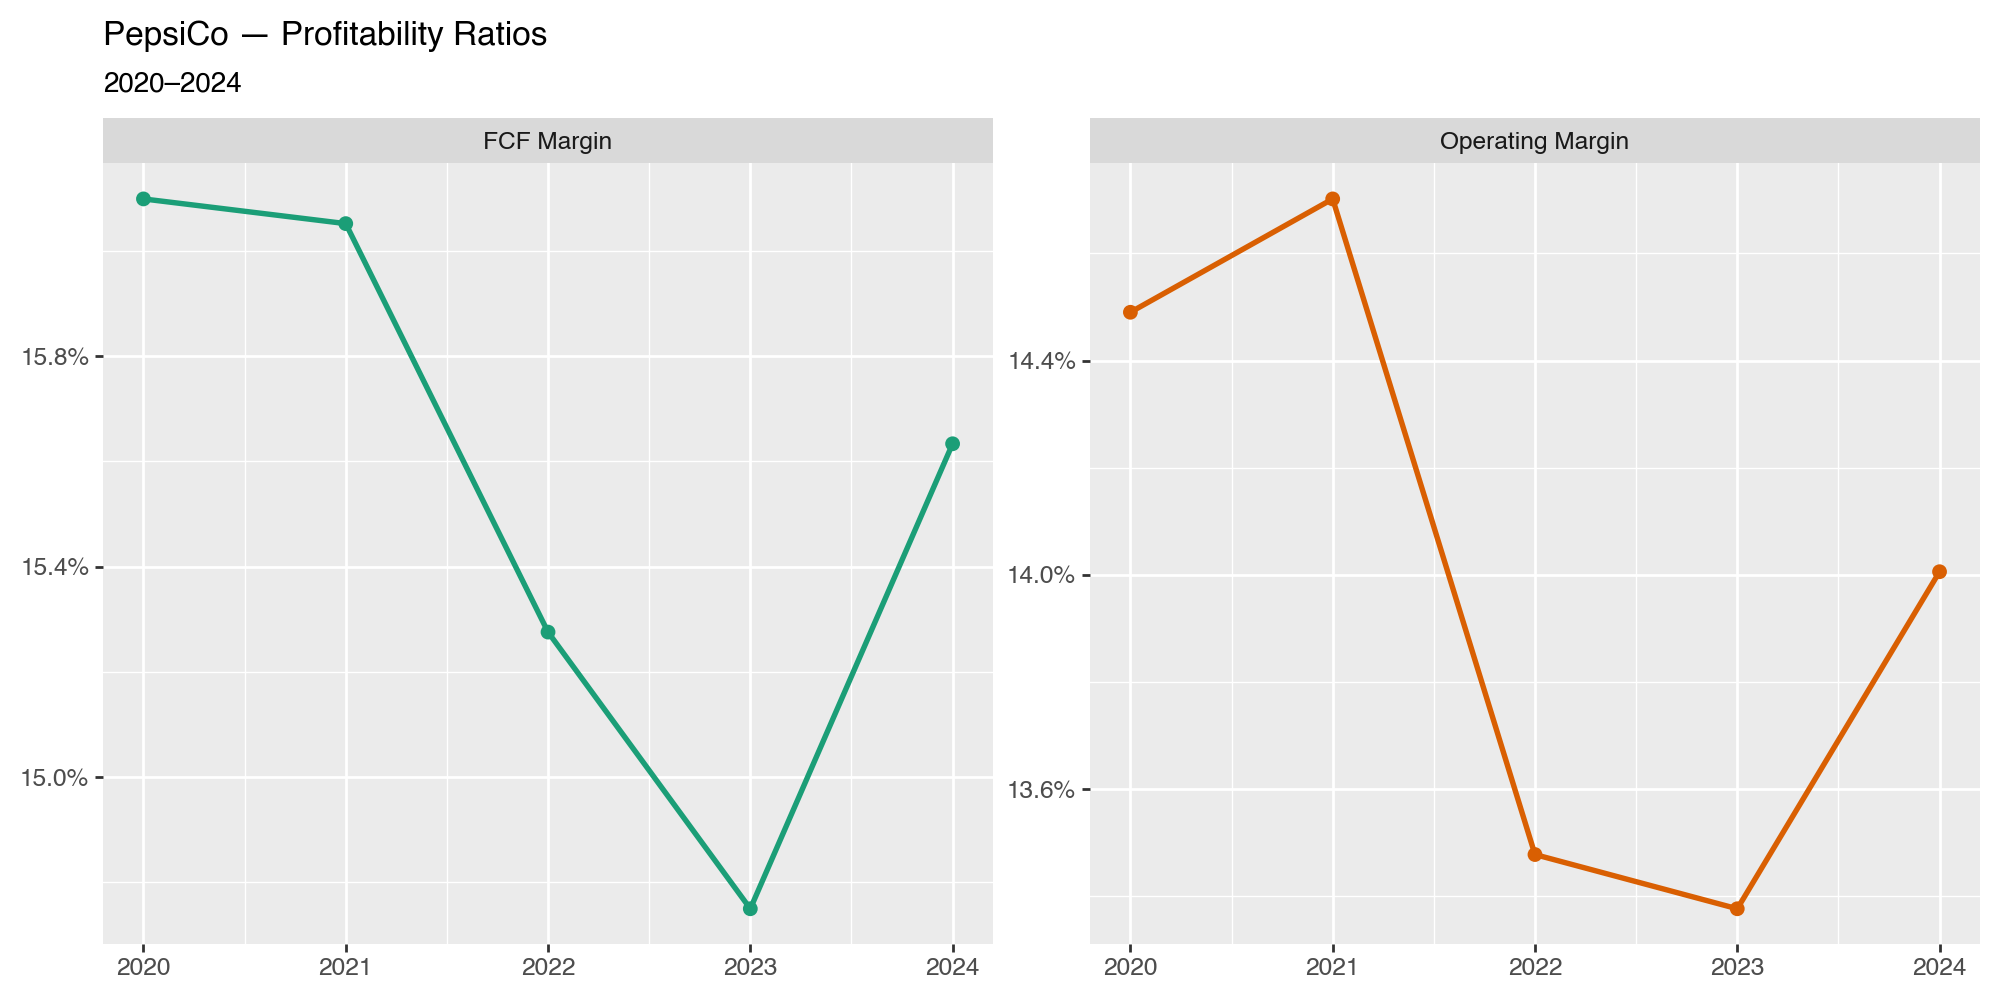

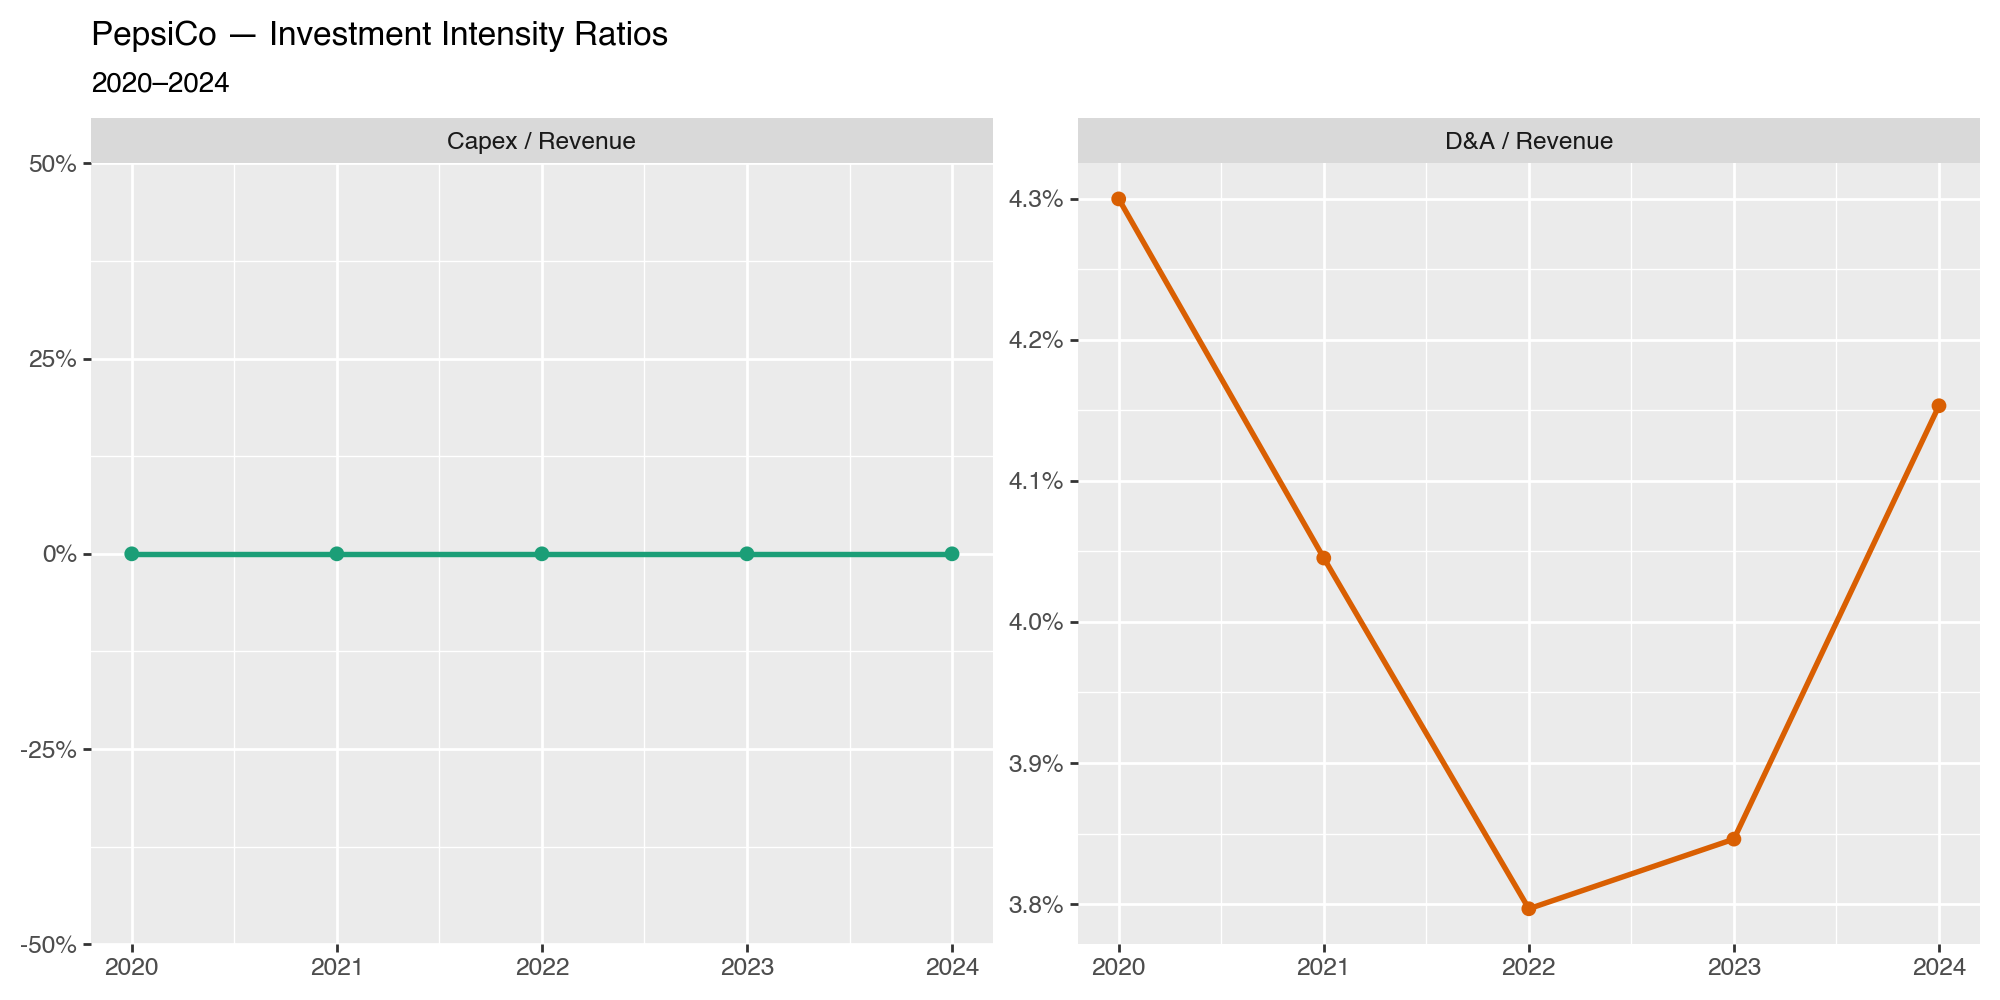

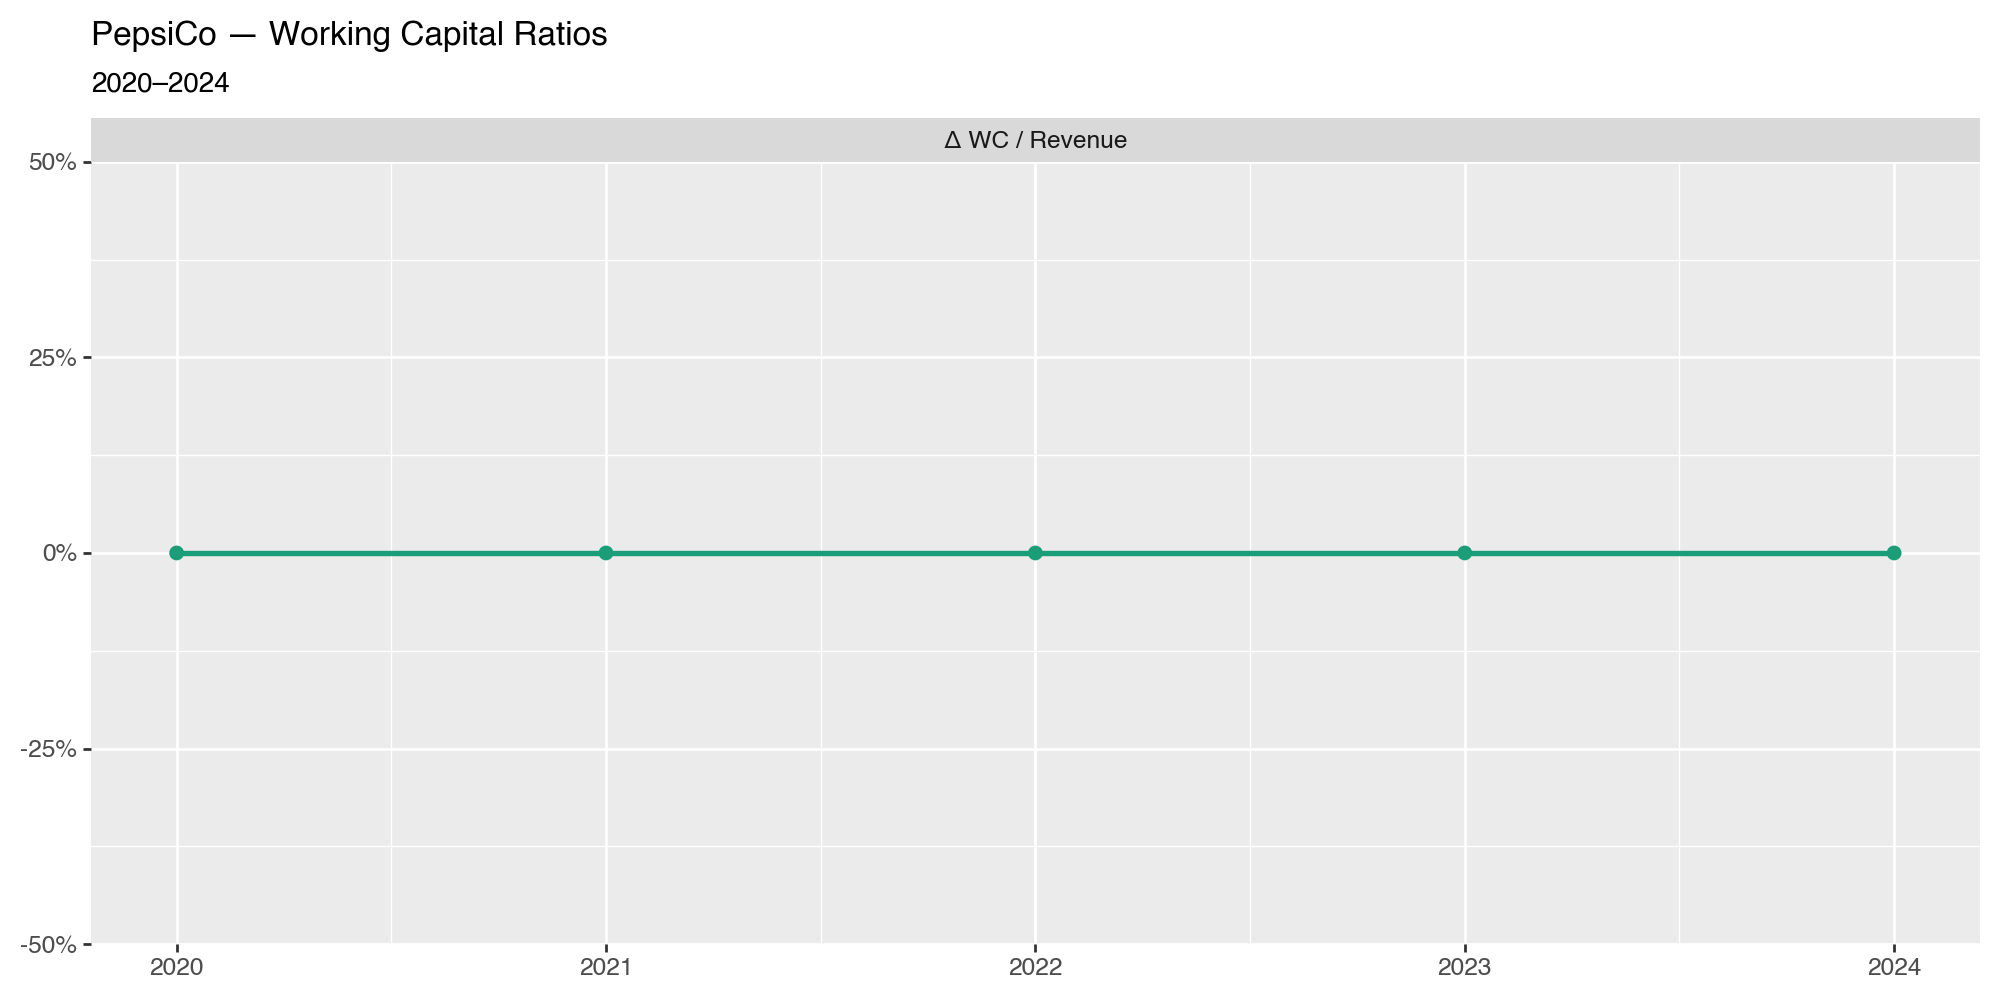

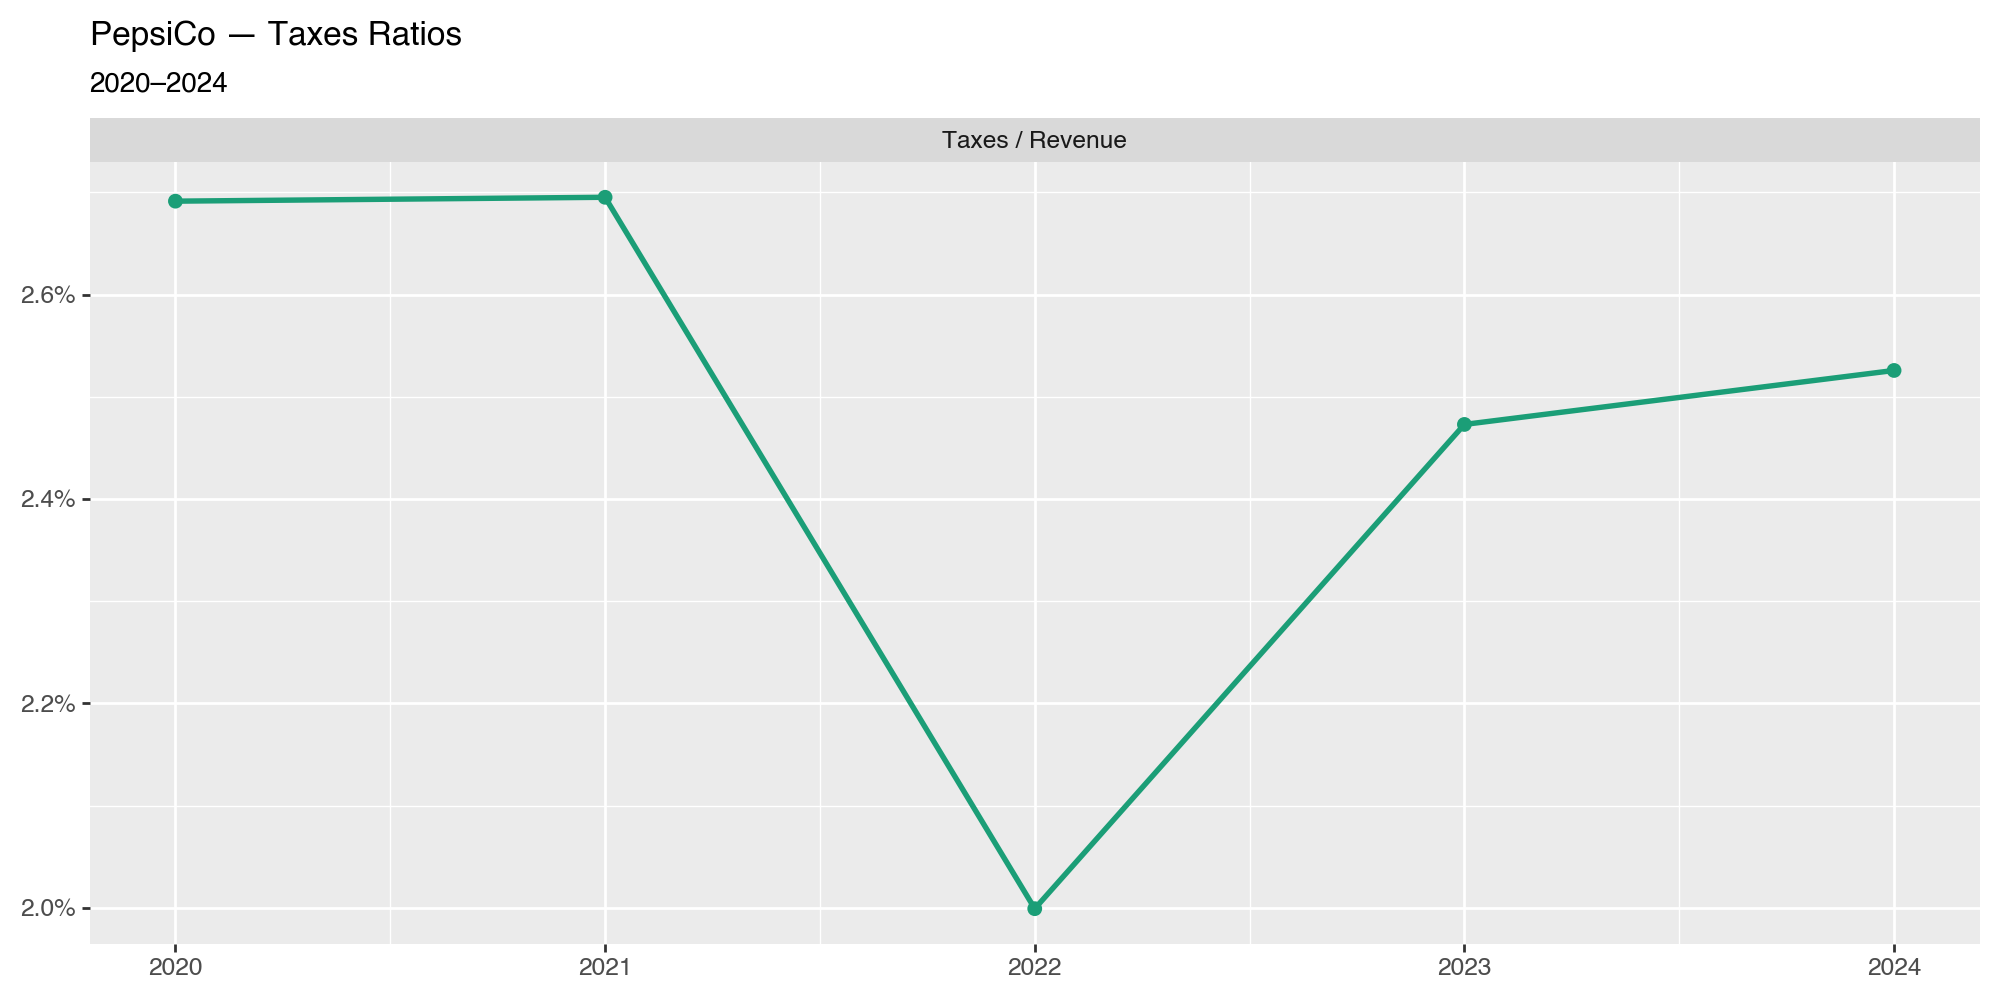

/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/anaconda3/envs/QF-Playground/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


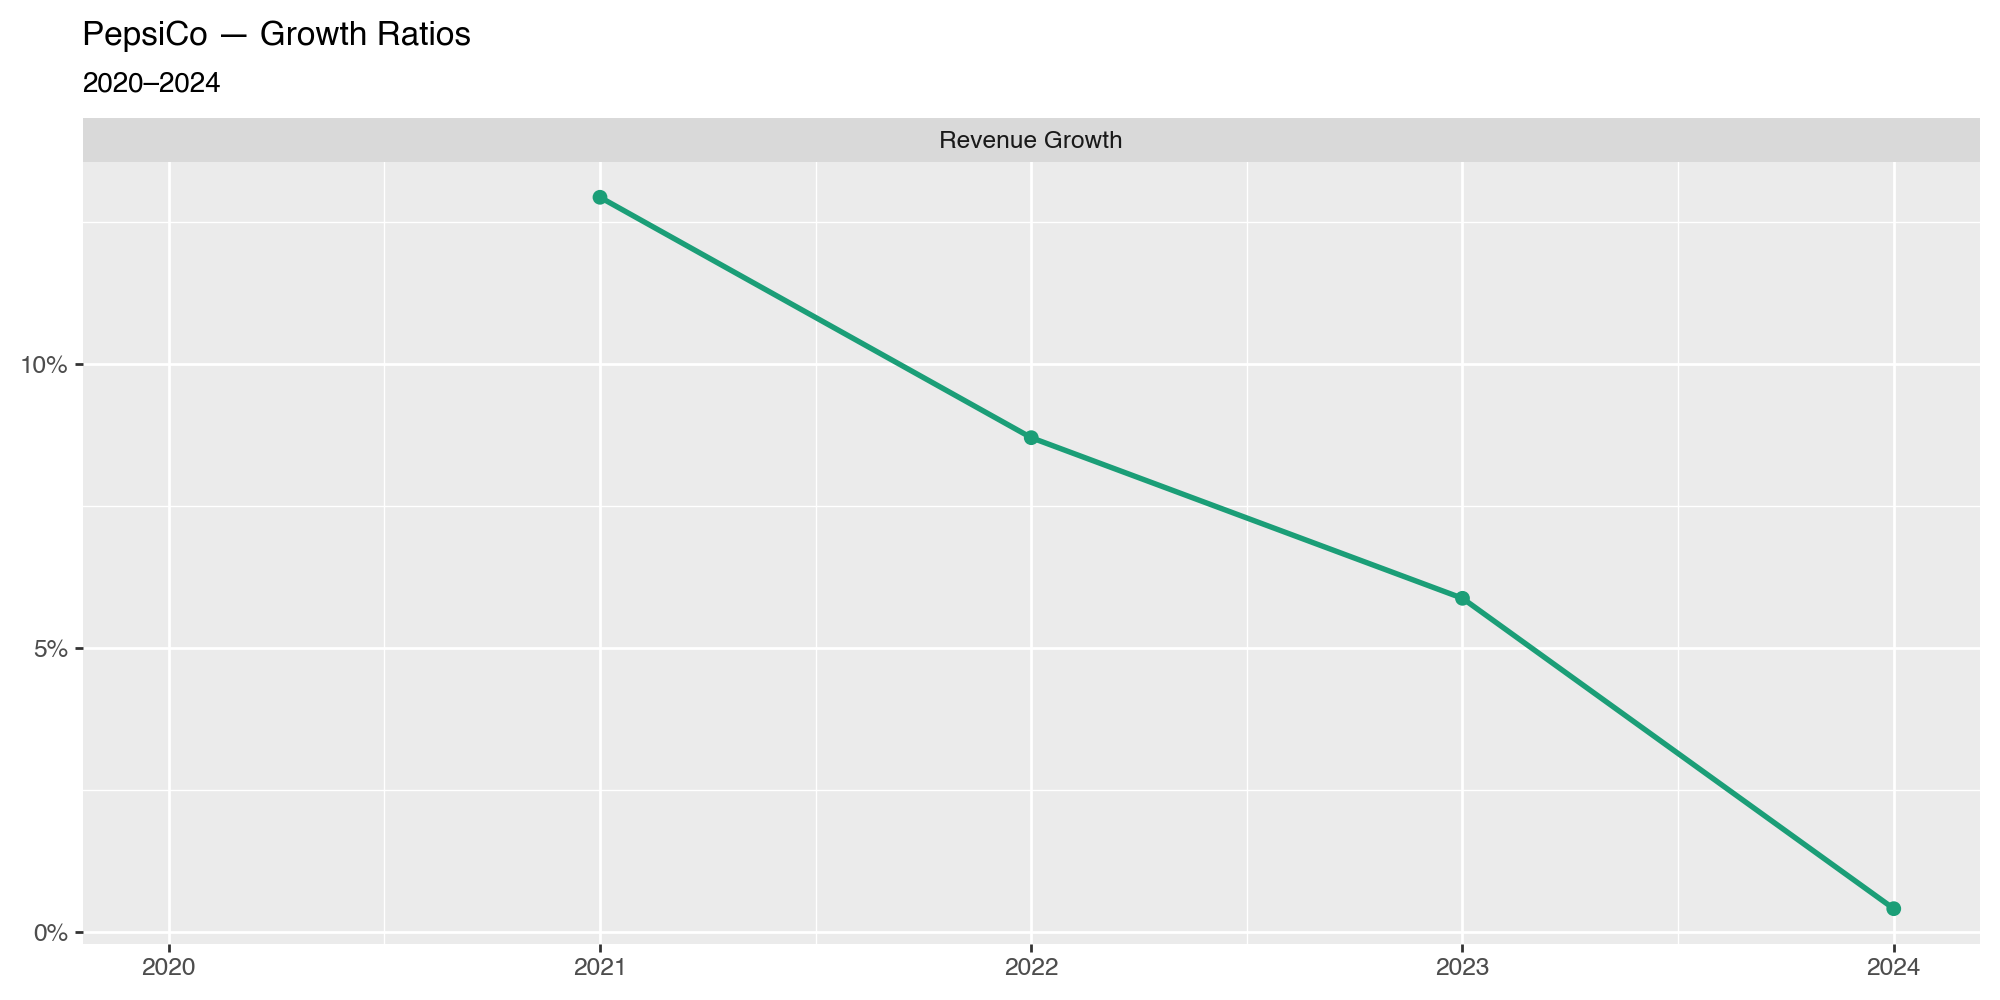

In [42]:
import numpy as np
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap, labs,
    scale_y_continuous, scale_color_brewer, theme, element_text
)
from mizani.formatters import percent_format

# 1) Ensure all ratios exist (add FCF margin)
dcf_data = (
    dcf_data
    .assign(
        revenue_growth=lambda df: df["revenue"].pct_change(),
        operating_margin=lambda df: np.where(df["revenue"] != 0, df["ebit"] / df["revenue"], np.nan),
        fcf_margin=lambda df: np.where(df["revenue"] != 0, df["fcf"] / df["revenue"], np.nan),
        da_margin=lambda df: np.where(df["revenue"] != 0, df["depreciationAndAmortization"] / df["revenue"], np.nan),
        taxes_to_revenue=lambda df: np.where(df["revenue"] != 0, df["taxes"] / df["revenue"], np.nan),
        delta_working_capital_to_revenue=lambda df: np.where(df["revenue"] != 0, df["delta_working_capital"] / df["revenue"], np.nan),
        capex_to_revenue=lambda df: np.where(df["revenue"] != 0, df["capex"] / df["revenue"], np.nan),
    )
    .replace([np.inf, -np.inf], np.nan)
)

# 2) Define classes of ratios
ratio_classes = {
    "Profitability": [
        "operating_margin",   # EBIT / Revenue
        "fcf_margin",         # FCF / Revenue
    ],
    "Investment Intensity": [
        "capex_to_revenue",   # Capex / Revenue
        "da_margin",          # D&A / Revenue
    ],
    "Working Capital": [
        "delta_working_capital_to_revenue",  # ΔWC / Revenue
    ],
    "Taxes": [
        "taxes_to_revenue",   # Taxes / Revenue
    ],
    "Growth": [
        "revenue_growth",     # Revenue growth YoY
    ],
}

# Pretty names
pretty = {
    "operating_margin": "Operating Margin",
    "fcf_margin": "FCF Margin",
    "capex_to_revenue": "Capex / Revenue",
    "da_margin": "D&A / Revenue",
    "delta_working_capital_to_revenue": "Δ WC / Revenue",
    "taxes_to_revenue": "Taxes / Revenue",
    "revenue_growth": "Revenue Growth",
}

# 3) Make a long frame of all ratios we care about
all_ratio_names = [n for group in ratio_classes.values() for n in group]
ratios_long = (
    dcf_data[["year"] + all_ratio_names]
      .melt(id_vars="year", var_name="indicator", value_name="value")
      .assign(indicator=lambda df: df["indicator"].map(lambda s: pretty.get(s, s)))
)

# helper to plot one class
def plot_ratio_class(class_name, ncol=2):
    subset = ratio_classes[class_name]
    use_names = [pretty.get(n, n) for n in subset]
    df = ratios_long[ratios_long["indicator"].isin(use_names)].copy()
    return (
        ggplot(df, aes("year", "value", color="indicator", group="indicator"))
        + geom_line(size=1.1)
        + geom_point(size=2.0)
        + facet_wrap("~indicator", scales="free_y", ncol=ncol)
        + scale_y_continuous(labels=percent_format())
        + scale_color_brewer(type="qualitative", palette="Dark2")
        + labs(
            title=f"PepsiCo — {class_name} Ratios",
            subtitle=f"{int(dcf_data['year'].min())}–{int(dcf_data['year'].max())}",
            x="", y="", color=""
        )
        + theme(
            figure_size=(10, 5),
            axis_text_x=element_text(rotation=0, ha="center"),
            legend_position="none",
            plot_title=element_text(weight="bold", size=12),
            plot_subtitle=element_text(size=10),
        )
    )

# 4) Build plots per class (show the ones you want)
plot_profitability = plot_ratio_class("Profitability", ncol=2)
plot_investment    = plot_ratio_class("Investment Intensity", ncol=2)
plot_working_cap   = plot_ratio_class("Working Capital", ncol=1)
plot_taxes         = plot_ratio_class("Taxes", ncol=1)
plot_growth        = plot_ratio_class("Growth", ncol=1)

# Display
plot_profitability.show()
plot_investment.show()
plot_working_cap.show()
plot_taxes.show()
plot_growth.show()
